# TELECOM CHURN PREDICTION

## 1 - Introdução e Descrição de Variáveis

## 2 - Importando Bibliotecas

In [1]:
#pip install graphviz==0.19.0
#pip install missingno

In [2]:
#Pacotes Básicos
import numpy as np
import pandas as pd
import sklearn as sk
import time
from statistics import mean, median, mode, stdev 

#Visualização de Dados
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Modelos de Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier)
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Pacotes Auxiliares
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
from sklearn.base import clone

#Pré Processamento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder   
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

#Avaliação e Explicabilidade
from sklearn.metrics import (accuracy_score,
                             balanced_accuracy_score,
                             auc, 
                             precision_score,
                             recall_score,
                             f1_score, 
                             roc_auc_score,
                             confusion_matrix)
from lime import lime_tabular
from yellowbrick.model_selection import FeatureImportances
import xgbfir
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import scikitplot as skplt
from yellowbrick.classifier import DiscriminationThreshold

## 3 - Configurações e Funções Úteis

In [3]:
#Configurando paletas e definindo máximo de colunas e de linhas

pd.options.display.max_columns = None
pd.options.display.max_rows = None
sns.set_palette("rocket")
sns.set_style("whitegrid")
seed = 42

In [4]:
#Função para Treinar modelo e avaliar (cross validation com n folds)

def analisa_metricas_cross_val(clf, X_train, y_train, n_folds):
    
    #Iniciando tempo
    t=time.time()
    
    #inicío do plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    #Titulo
    plt.title('Avaliação \n', loc= 'left',fontdict ={'fontsize': 15})
    
    #Definindo DataFrame com Métricas de Avaliação 
    metrics_names=['ACCURACY SCORE', 'BALANCED ACCURACY SCORE', 'PRECISION SCORE', 'RECALL SCORE',
                  'F1 SCORE', 'AUC SCORE']
    metrics=["{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="accuracy"))),
            "{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="balanced_accuracy"))),
            "{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="precision"))),
            "{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="recall"))),
            "{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="f1"))),
            "{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="roc_auc")))]
    
    metric_df = pd.DataFrame()
    metric_df["metrics_names"]=metrics_names
    metric_df["#"]=metrics
    
    #Criando Tabela a partir de DataFrame com Métricas
    axs[1].axis('tight')
    axs[1].axis('off') 
    axs[1].table(cellText=metric_df.values, colLabels=metric_df.columns, loc='center', cellLoc ="center", fontsize=20,
                 colWidths=[0.6, 0.6])
    fig.tight_layout()
    
    #Definindo Matriz de Confusão
    y_pred = cross_val_predict(clf, X_train, y_train, cv=n_folds)
    cm = confusion_matrix(y_train, y_pred)
    
    #Cria um dataframe com a matriz de confusao
    df_cm = pd.DataFrame(cm,
                     index = ['0','1'], 
                     columns = ['0','1'])

    sns.heatmap(df_cm, annot=True,cmap='Blues', cbar = 0, fmt='d', ax=axs[0])
    axs[0].set_xlabel('Predicted label')
    axs[0].set_ylabel('True label')
    
    #Finalizando e printando tempo
    Time = time.time() - t
                                
    print("\nDone in %f s  \n \n" %Time)

In [5]:
#Função para Treinar modelo e avaliar (cross validation com n folds)

def analisa_metricas_treino_teste(clf, X_train, y_train, X_test, y_test, n_folds):

    #Reordenando colunas de dataframes de treino e teste
    X_test = X_test[X_train.columns]
    
    #Iniciando tempo
    t=time.time()
    
    #######AVALIAÇÃO NO TREINO
    
    #inicío do plot
    fig, axs = plt.subplots(2, 2, figsize=(15, 6))
    
    #Titulo Treino
    axs[0][0].set_title("Avaliação Treino", fontdict={'fontsize':20})
    
    #Definindo DataFrame com Métricas de Avaliação 
    metrics_names=['ACCURACY SCORE', 'BALANCED ACCURACY SCORE', 'PRECISION SCORE', 'RECALL SCORE',
                  'F1 SCORE', 'AUC SCORE']
    
    metrics=["{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="accuracy"))),
            "{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="balanced_accuracy"))),
            "{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="precision"))),
            "{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="recall"))),
            "{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="f1"))),
            "{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="roc_auc")))]
    
    metric_df = pd.DataFrame()
    metric_df["metrics_names"]=metrics_names
    metric_df["#"]=metrics
    
    #Criando Tabela a partir de DataFrame com Métricas
    axs[0][0].axis('tight')
    axs[0][0].axis('off') 
    axs[0][0].table(cellText=metric_df.values, colLabels=metric_df.columns, loc='center', cellLoc ="center", fontsize=20,
                 colWidths=[0.6, 0.4])
    
    #Definindo Matriz de Confusão
    y_pred = cross_val_predict(clf, X_train, y_train, cv=n_folds)
    cm = confusion_matrix(y_train, y_pred)
    
    #Cria um dataframe com a matriz de confusao
    df_cm = pd.DataFrame(cm,
                     index = ['0','1'], 
                     columns = ['0','1'])

    sns.heatmap(df_cm, annot=True,cmap='Blues', cbar = 0, fmt='d', ax=axs[1][0])
    axs[1][0].set_xlabel('Predicted label')
    axs[1][0].set_ylabel('True label')
    
    #######AVALIAÇÃO NO TESTE
    
    #Titulo Test
    axs[0][1].set_title("Avaliação Teste", fontdict={'fontsize':20}) 
    
    #Realiza Previsões
    y_pred = clf.predict(X_test)
    
    #Cria DataFrame com métricas
    try:
        #Calcula Probabilidades
        y_test_prob = clf.predict_proba(X_test)

        metrics_names=['ACCURACY SCORE', 'BALANCED ACCURACY SCORE', 'PRECISION SCORE', 'RECALL SCORE',
          'F1 SCORE', 'AUC SCORE']              
        #Cria lista com métricas calculadas
        metrics=["{:.3f}".format(accuracy_score(y_test, y_pred)),
            "{:.3f}".format(balanced_accuracy_score(y_test, y_pred)),
            "{:.3f}".format(precision_score(y_test, y_pred)),
            "{:.3f}".format(recall_score(y_test, y_pred)),
            "{:.3f}".format(f1_score(y_test, y_pred)),
            "{:.3f}".format(roc_auc_score(y_test,y_test_prob[:,1]))]
    except:
                                
        #Caso modelo não possua método predict_proba
        metrics_names=['ACCURACY SCORE', 'BALANCED ACCURACY SCORE', 'PRECISION SCORE', 'RECALL SCORE',
          'F1 SCORE']                      

        metrics=["{:.3f}".format(accuracy_score(y_test, y_pred)),
            "{:.3f}".format(balanced_accuracy_score(y_test, y_pred)),
            "{:.3f}".format(precision_score(y_test, y_pred)),
            "{:.3f}".format(recall_score(y_test, y_pred)),
            "{:.3f}".format(f1_score(y_test, y_pred))]
                                
    metric_df = pd.DataFrame()
    metric_df["metrics_names"]=metrics_names
    metric_df["#"]=metrics                           
    
    #Criando Tabela a partir de DataFrame com Métricas
    axs[0][1].axis('tight')
    axs[0][1].axis('off') 
    axs[0][1].table(cellText=metric_df.values, colLabels=metric_df.columns, loc='center', cellLoc ="center", fontsize=20,
                 colWidths=[0.6, 0.4])
    
    #Definindo Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    
    #Cria um dataframe com a matriz de confusao
    df_cm = pd.DataFrame(cm,
                     index = ['0','1'], 
                     columns = ['0','1'])

    sns.heatmap(df_cm, annot=True,cmap='Blues', cbar = 0, fmt='d', ax=axs[1][1])
    axs[1][1].set_xlabel('Predicted label')
    axs[1][1].set_ylabel('True label')
    
    #Finalizando e printando tempo
    Time = time.time() - t
                                
    print("\nDone in %f s  \n \n" %Time)

In [6]:
def treina_avalia_compara(clf_dict, X_train, y_train, n_folds):
    
    #Iniciando tempo
    t=time.time()    
    
    #Inicializando listas de métricas
    acc=[]
    blc_acc=[]
    prc=[]
    rec=[]
    f1=[]
    roc=[]
    
    #Loop para calcular métricas para todos os modelos e abastecer listas acima
    for clf in clf_dict.values():
        acc.append(float("{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="accuracy"))))),
        blc_acc.append(float("{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="balanced_accuracy"))))),
        prc.append(float("{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="precision"))))),
        rec.append(float("{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="recall"))))),
        f1.append(float("{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="f1"))))),
        roc.append(float("{:.3f}".format(mean(cross_val_score(clf, X_train, y_train, cv=n_folds, scoring="roc_auc")))))
    
    #Cria DataFrame com uma coluna para cada métrica e uma linha para cada modelo
    clf_df=pd.DataFrame(index=clf_dict.keys())
    clf_df['ACCURACY']=acc
    clf_df['BALANCED ACCURACY']=blc_acc
    clf_df['PRECISION']=prc
    clf_df['RECALL']=rec
    clf_df['F1 SCORE']=f1
    clf_df['ROC AUC SCORE']=roc
    
    #Cria um heatmap para cada coluna
    fig, axs = plt.subplots(1, 6)
    ax1=sns.heatmap(clf_df[['ACCURACY']], annot=True, cmap="Greens", ax= axs[0], cbar=False)
    ax1.set_xticklabels(labels=['ACCURACY'], rotation=45, fontdict={'horizontalalignment':'right', 'fontsize': 10})
    ax2=sns.heatmap(clf_df[['BALANCED ACCURACY']], annot=True, cmap="Greens", ax= axs[1], yticklabels=False, cbar=False)
    ax2.set_xticklabels(labels=['BALANCED \nACCURACY'], rotation=45, fontdict={'horizontalalignment':'right', 'fontsize': 10})
    ax3=sns.heatmap(clf_df[['PRECISION']], annot=True, cmap="Greens", ax= axs[2], yticklabels=False, cbar=False)
    ax3.set_xticklabels(labels=['PRECISION'], rotation=45, fontdict={'horizontalalignment':'right', 'fontsize': 10})
    ax3.set_title('Comparativo Métricas \n', loc= 'left',fontdict ={'fontsize': 15})
    ax4=sns.heatmap(clf_df[['RECALL']], annot=True, cmap="Greens", ax= axs[3], yticklabels=False, cbar=False)
    ax4.set_xticklabels(labels=['RECALL'], rotation=45, fontdict={'horizontalalignment':'right', 'fontsize': 10})
    ax5=sns.heatmap(clf_df[['F1 SCORE']], annot=True, cmap="Greens", ax= axs[4], yticklabels=False, cbar=False)
    ax5.set_xticklabels(labels=['F1 SCORE'], rotation=45, fontdict={'horizontalalignment':'right', 'fontsize': 10})
    ax6=sns.heatmap(clf_df[['ROC AUC SCORE']], annot=True, cmap="Greens", ax= axs[5], yticklabels=False, cbar=False)
    ax6.set_xticklabels(labels=['ROC AUC \nSCORE'], rotation=45, fontdict={'horizontalalignment':'center', 'fontsize': 10})
    
    plt.show()
    
    #Finalizando e printando tempo
    Time = time.time() - t
    print("\nDone in %f s  \n \n" %Time)

## 4 - Análise Inicial da Base De Dados

In [7]:
#Importando base de dados

churn_data = pd.read_csv("telecom_churn.csv")

In [8]:
#Visualizando primeiras linhas

churn_data.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [9]:
#Visualizando principais estatísticas referentes a base de dados

churn_data.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
Churn,3333.00,0.14,0.35,0.00,0.00,0.00,0.00,1.00
AccountWeeks,3333.00,101.06,39.82,1.00,74.00,101.00,127.00,243.00
ContractRenewal,3333.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
DataPlan,3333.00,0.28,0.45,0.00,0.00,0.00,1.00,1.00
DataUsage,3333.00,0.82,1.27,0.00,0.00,0.00,1.78,5.40
CustServCalls,3333.00,1.56,1.32,0.00,1.00,1.00,2.00,9.00
DayMins,3333.00,179.78,54.47,0.00,143.70,179.40,216.40,350.80
DayCalls,3333.00,100.44,20.07,0.00,87.00,101.00,114.00,165.00
MonthlyCharge,3333.00,56.31,16.43,14.00,45.00,53.50,66.20,111.30
OverageFee,3333.00,10.05,2.54,0.00,8.33,10.07,11.77,18.19


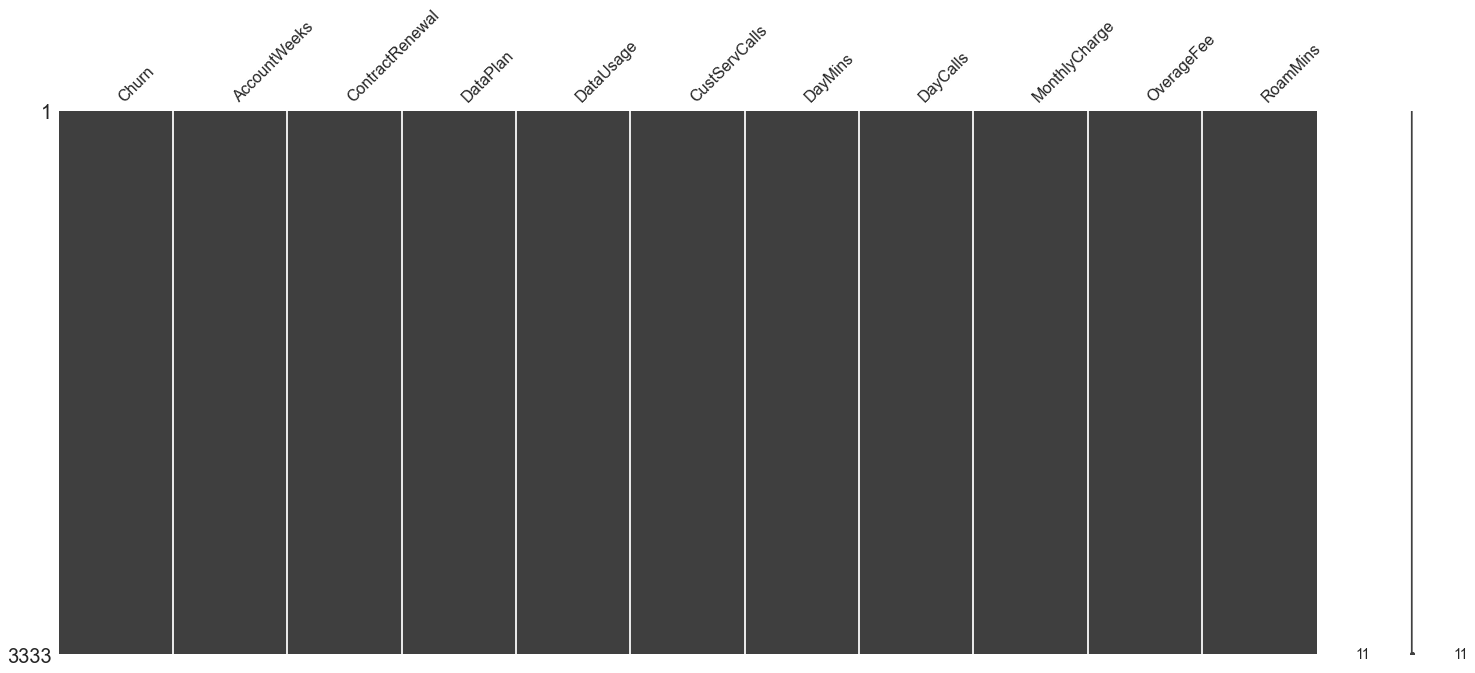

In [10]:
#Verificando valores nulos

msno.matrix(churn_data)

In [11]:
# Verificando tipos de variáveis

churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [12]:
#Verificando quantidade de linhas e colunas

churn_data.shape

(3333, 11)

In [13]:
#Separando em Treino e teste

train_ds, test_ds = train_test_split(churn_data, test_size=0.2, 
                                                        random_state=seed, stratify=churn_data['Churn'])

In [14]:
train_ds.shape

(2666, 11)

In [15]:
test_ds.shape

(667, 11)

## 5 - Análise Exploratória

## 5.1 - Variáveis Contínuas

### AccountWeeks 

In [16]:
#AccountWeeks - number of weeks customer has had active account

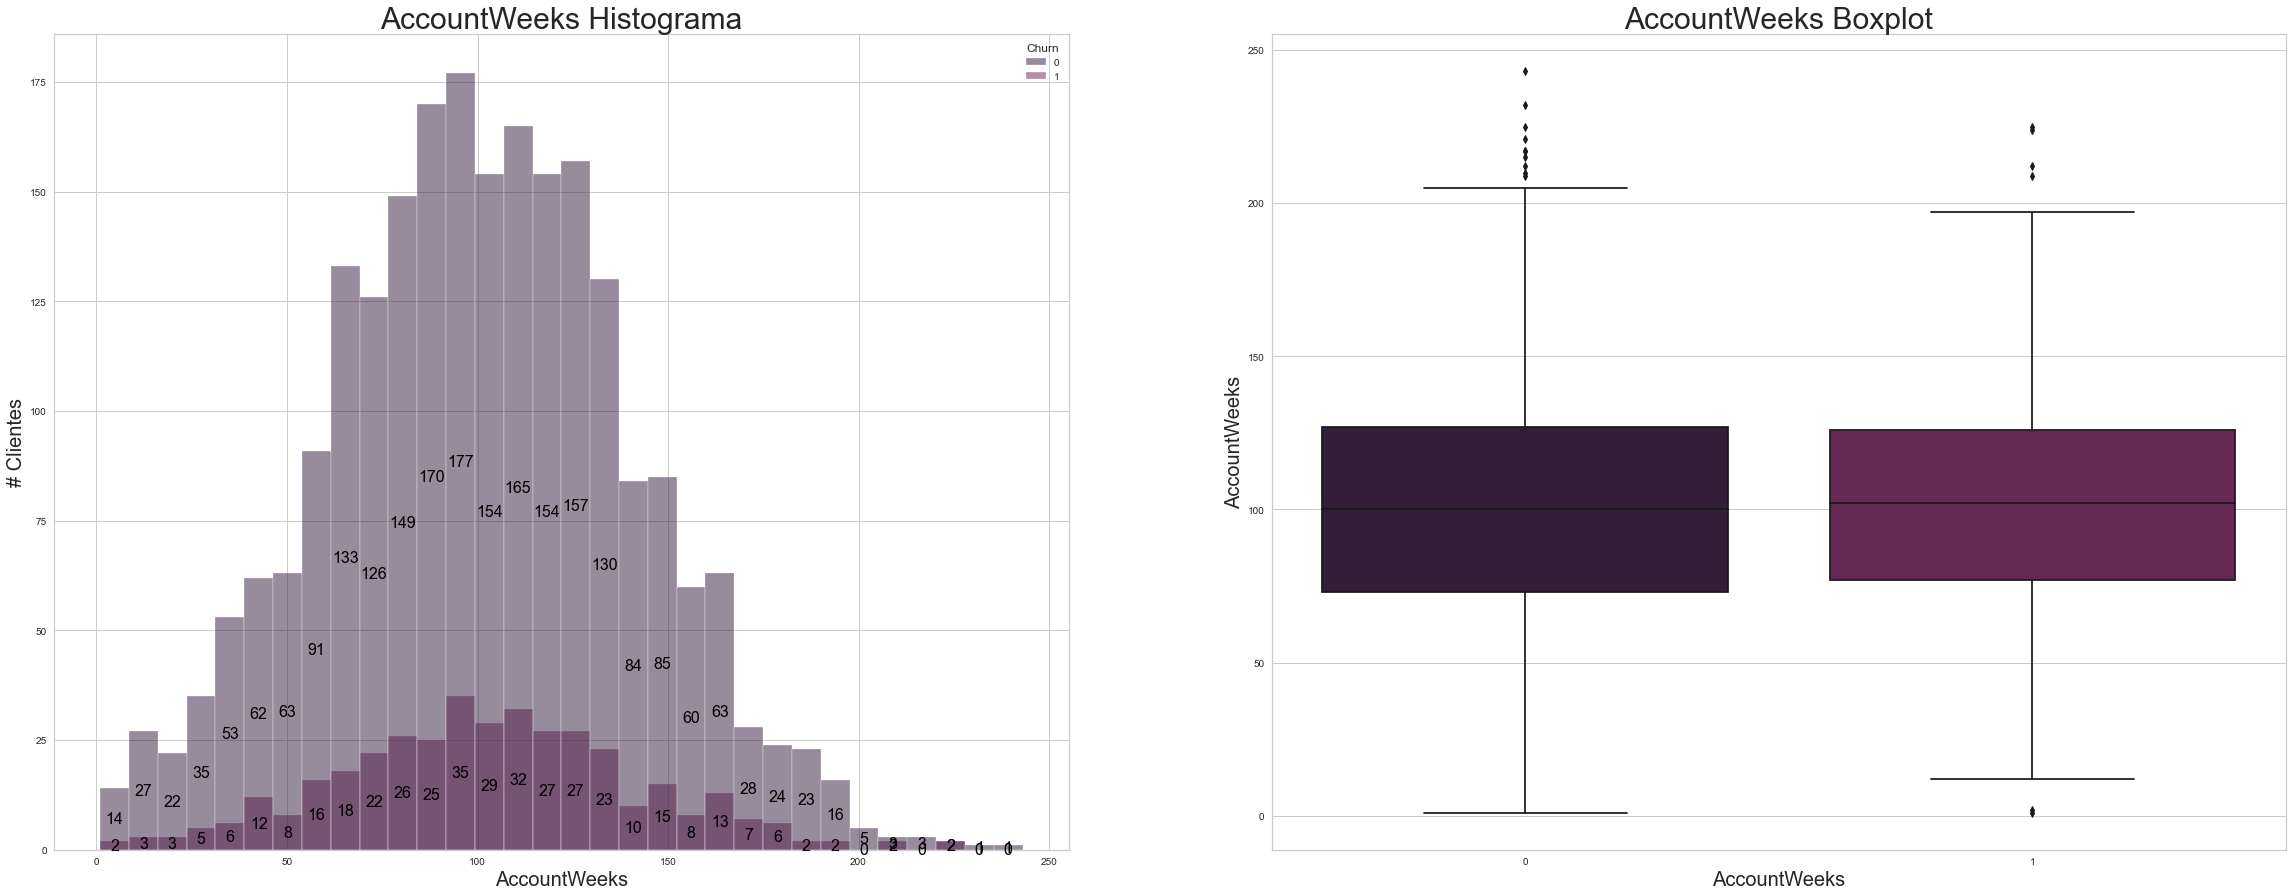

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(40, 15))

ax1 = sns.histplot(data = train_ds, x = 'AccountWeeks', hue = "Churn", ax=axs[0])
ax1.set_title('AccountWeeks Histograma', fontsize=30)
ax1.set_xlabel('AccountWeeks', fontsize=20)
ax1.set_ylabel('# Clientes', fontsize=20)
ax1.ticklabel_format(style='plain', axis='y')
for p in ax1.patches:
    ax1.annotate('{0:,}'.format(p.get_height()), (p.get_x()+p.get_width()/2, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=16)

ax2 = sns.boxplot(x="Churn", y="AccountWeeks", data=train_ds, ax=axs[1])
ax2.set_title('AccountWeeks Boxplot', fontsize=30)
ax2.set_xlabel('AccountWeeks', fontsize=20)
ax2.set_ylabel('AccountWeeks', fontsize=20)
ax2.ticklabel_format(style='plain', axis='y')

### DataUsage

In [18]:
#DataUsage - gigabytes of monthly data usage

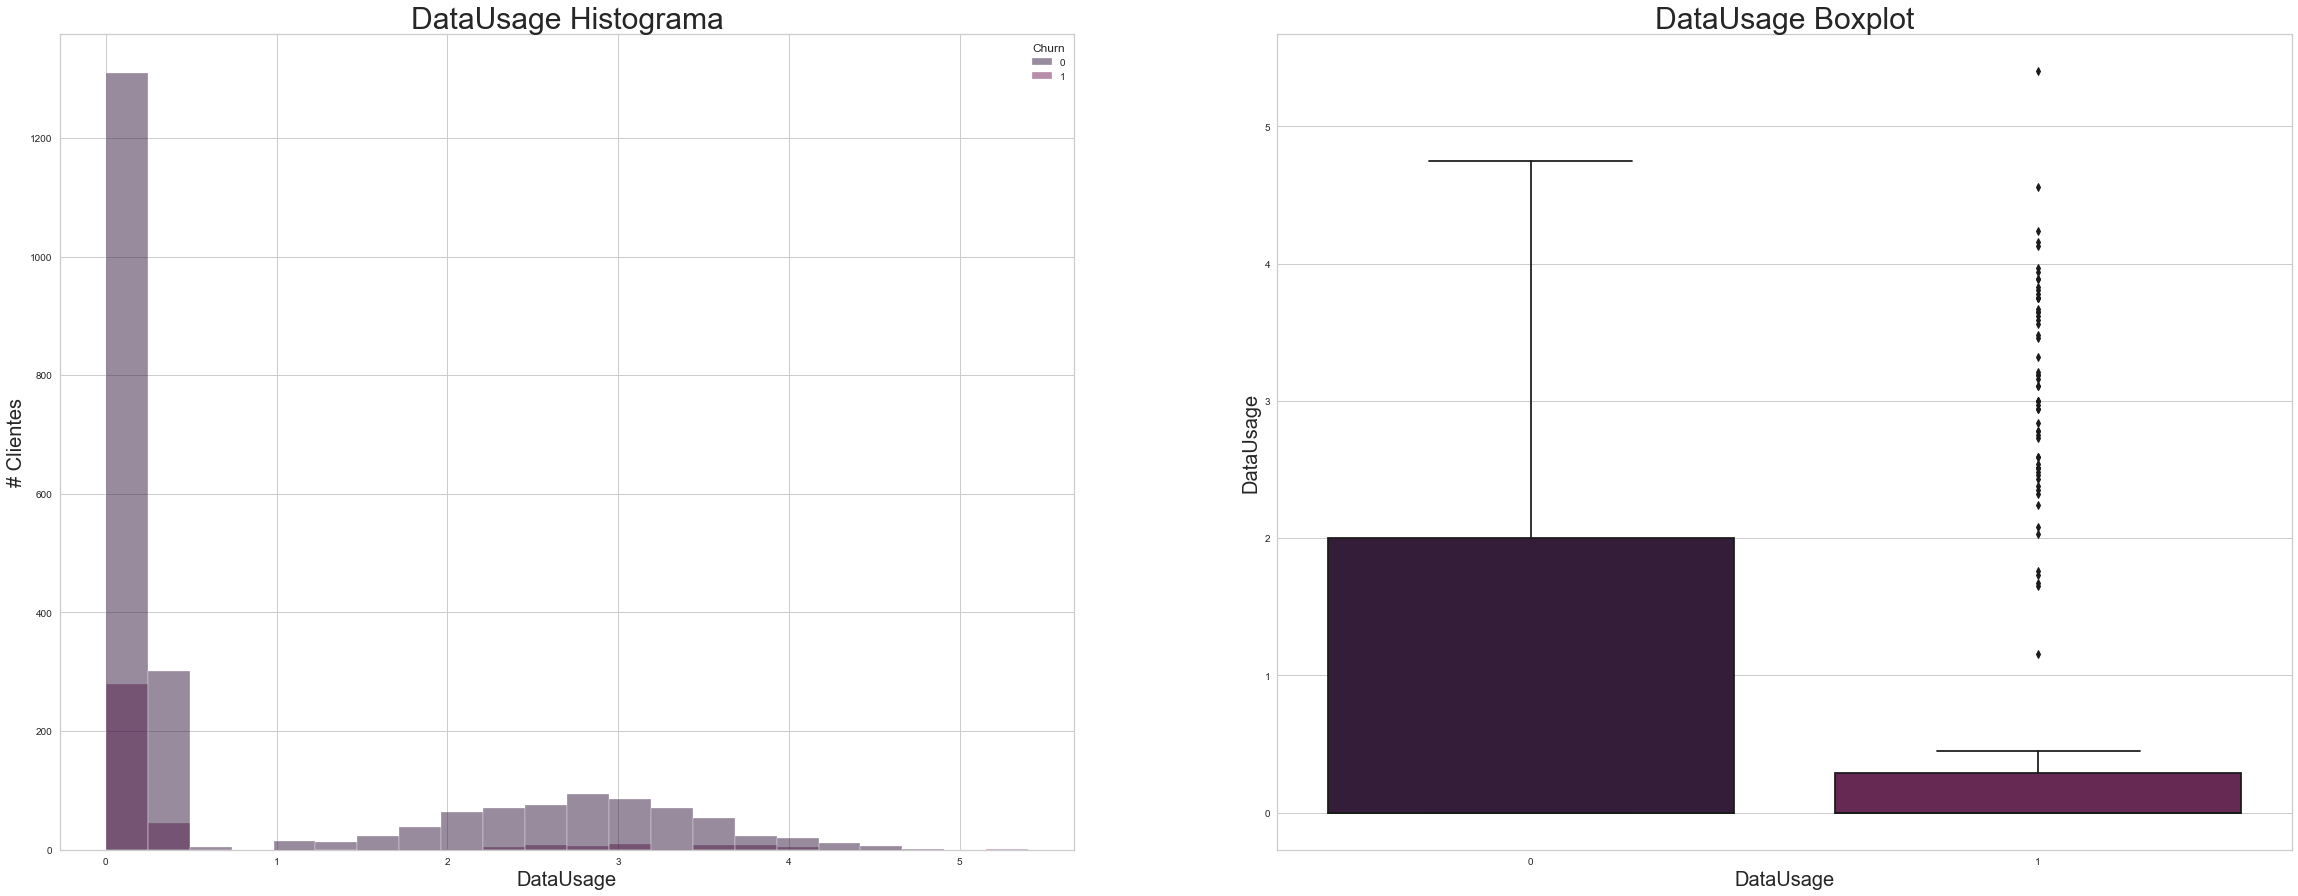

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(40, 15))

ax1 = sns.histplot(data = train_ds, x = 'DataUsage', hue = "Churn", ax=axs[0])
ax1.set_title('DataUsage Histograma', fontsize=30)
ax1.set_xlabel('DataUsage', fontsize=20)
ax1.set_ylabel('# Clientes', fontsize=20)
ax1.ticklabel_format(style='plain', axis='y')

ax2 = sns.boxplot(x="Churn", y="DataUsage", data=train_ds, ax=axs[1])
ax2.set_title('DataUsage Boxplot', fontsize=30)
ax2.set_xlabel('DataUsage', fontsize=20)
ax2.set_ylabel('DataUsage', fontsize=20)
ax2.ticklabel_format(style='plain', axis='y')

### CustSurvCalls

In [20]:
#CustSurvCalls - number of calls into customer service

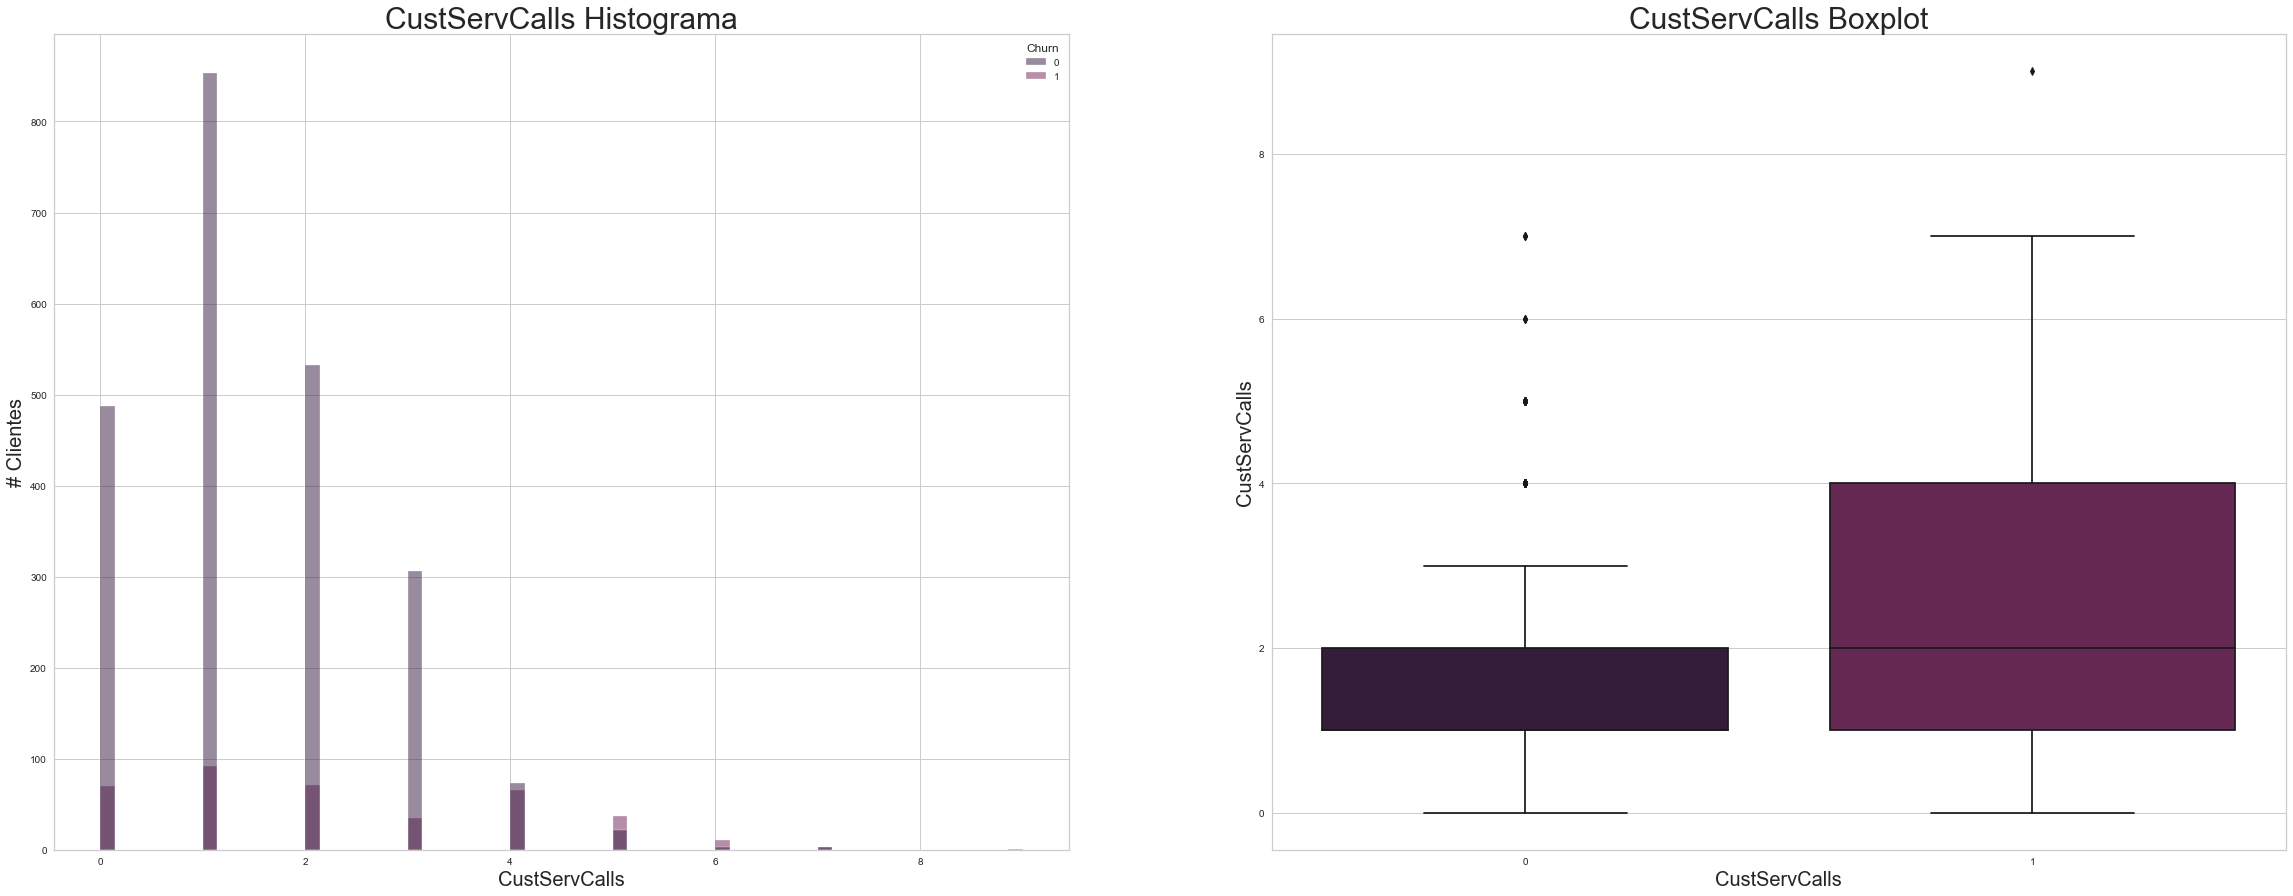

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(40, 15))

ax1 = sns.histplot(data = train_ds, x = 'CustServCalls', hue = "Churn", ax=axs[0])
ax1.set_title('CustServCalls Histograma', fontsize=30)
ax1.set_xlabel('CustServCalls', fontsize=20)
ax1.set_ylabel('# Clientes', fontsize=20)
ax1.ticklabel_format(style='plain', axis='y')

ax2 = sns.boxplot(x="Churn", y="CustServCalls", data=train_ds, ax=axs[1])
ax2.set_title('CustServCalls Boxplot', fontsize=30)
ax2.set_xlabel('CustServCalls', fontsize=20)
ax2.set_ylabel('CustServCalls', fontsize=20)
ax2.ticklabel_format(style='plain', axis='y')

### DayMins 

In [22]:
#DayMins - average daytime minutes per month

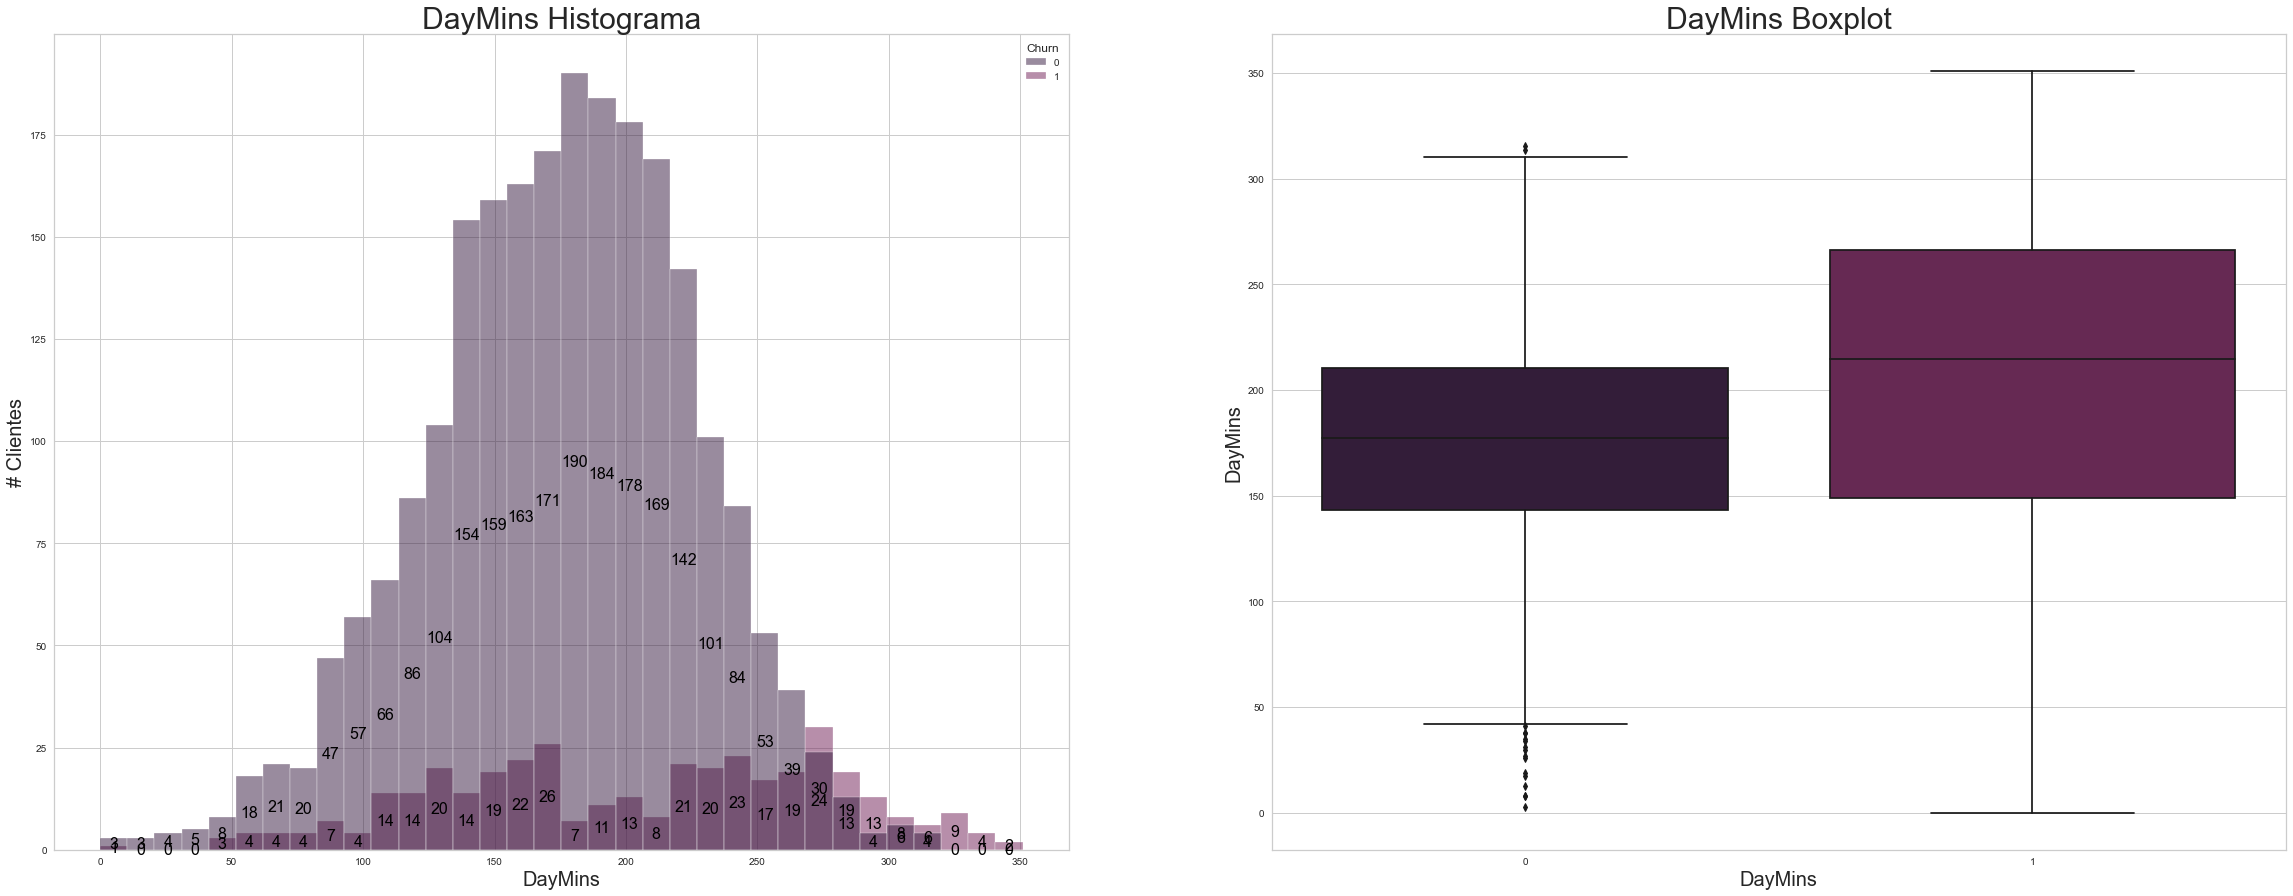

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(40, 15))

ax1 = sns.histplot(data = train_ds, x = 'DayMins', hue = "Churn", ax=axs[0])
ax1.set_title('DayMins Histograma', fontsize=30)
ax1.set_xlabel('DayMins', fontsize=20)
ax1.set_ylabel('# Clientes', fontsize=20)
ax1.ticklabel_format(style='plain', axis='y')
for p in ax1.patches:
    ax1.annotate('{0:,}'.format(p.get_height()), (p.get_x()+p.get_width()/2, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=16)

ax2 = sns.boxplot(x="Churn", y="DayMins", data=train_ds, ax=axs[1])
ax2.set_title('DayMins Boxplot', fontsize=30)
ax2.set_xlabel('DayMins', fontsize=20)
ax2.set_ylabel('DayMins', fontsize=20)
ax2.ticklabel_format(style='plain', axis='y')

### DayCalls

In [24]:
#DayCalls - average number of daytime calls

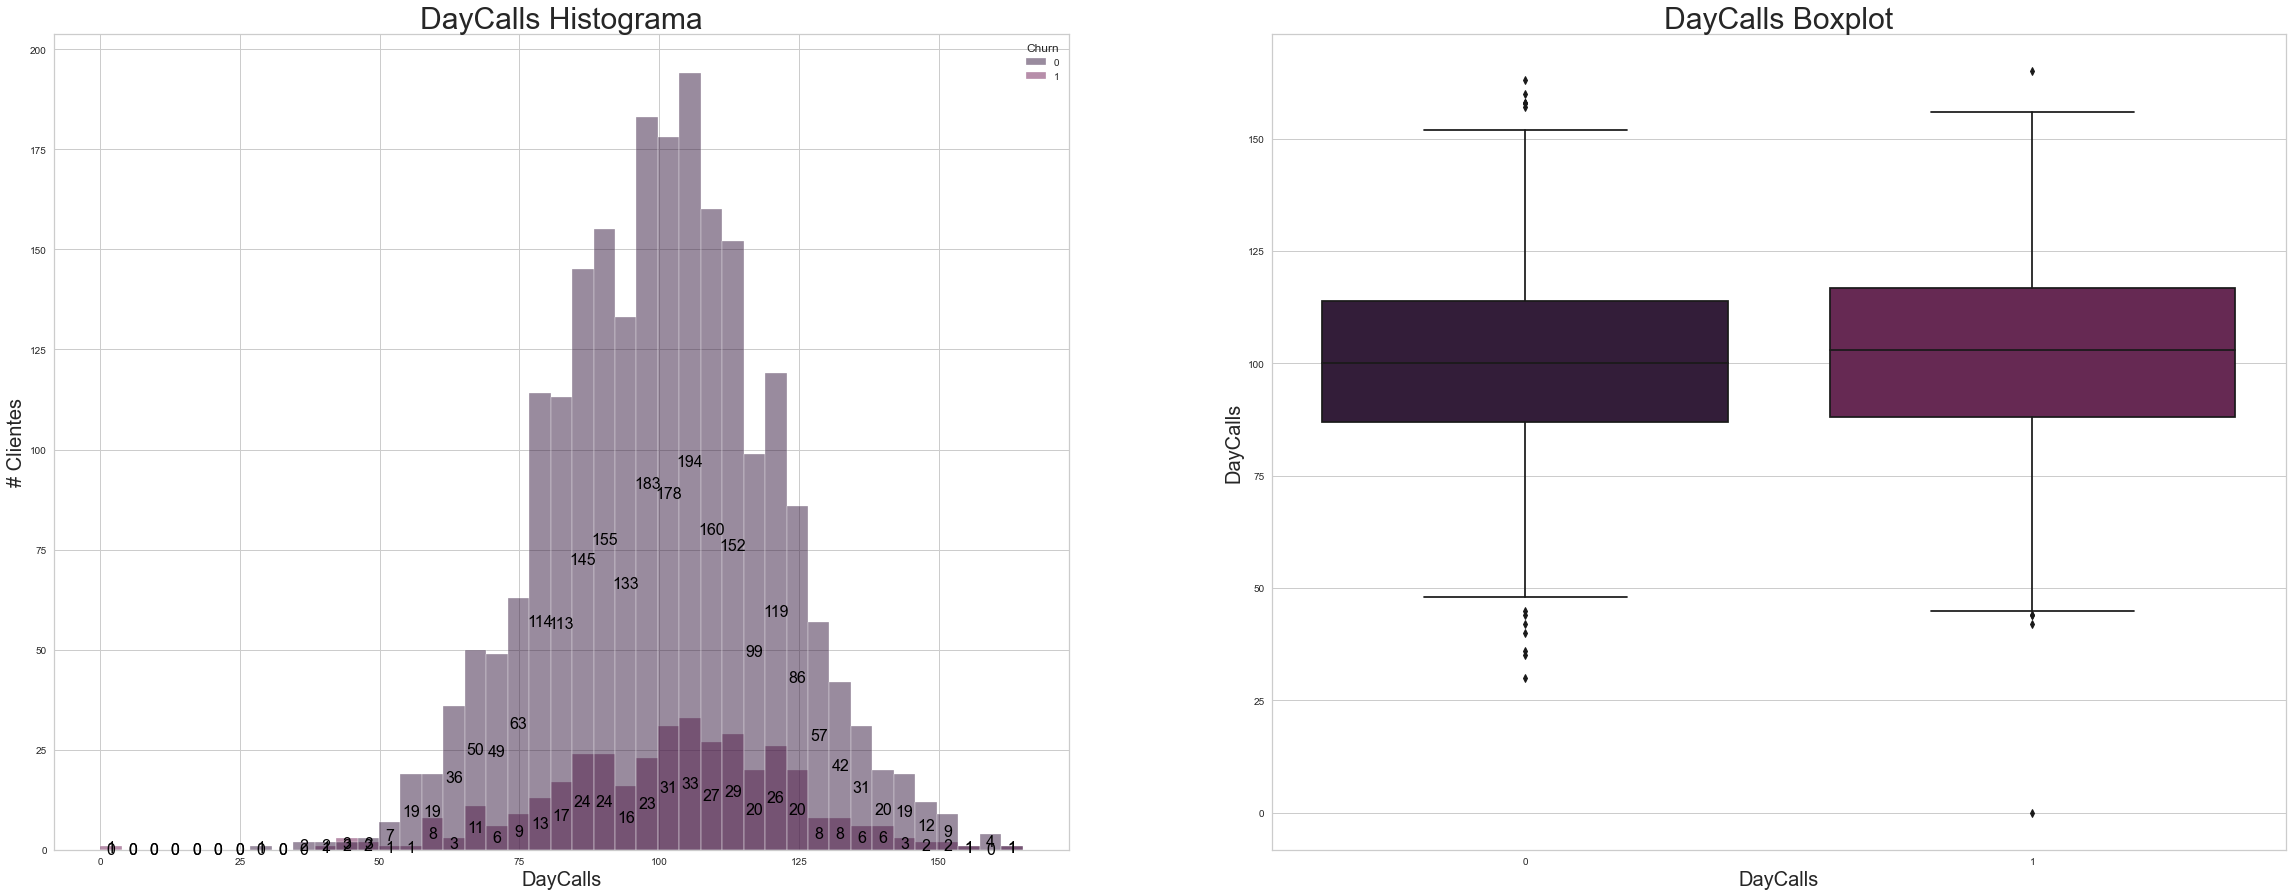

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(40, 15))

ax1 = sns.histplot(data = train_ds, x = 'DayCalls', hue = "Churn", ax=axs[0])
ax1.set_title('DayCalls Histograma', fontsize=30)
ax1.set_xlabel('DayCalls', fontsize=20)
ax1.set_ylabel('# Clientes', fontsize=20)
ax1.ticklabel_format(style='plain', axis='y')
for p in ax1.patches:
    ax1.annotate('{0:,}'.format(p.get_height()), (p.get_x()+p.get_width()/2, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=16)

ax2 = sns.boxplot(x="Churn", y="DayCalls", data=train_ds, ax=axs[1])
ax2.set_title('DayCalls Boxplot', fontsize=30)
ax2.set_xlabel('DayCalls', fontsize=20)
ax2.set_ylabel('DayCalls', fontsize=20)
ax2.ticklabel_format(style='plain', axis='y')

### MonthlyCharge

In [26]:
#MonthlyCharge - average monthly bill

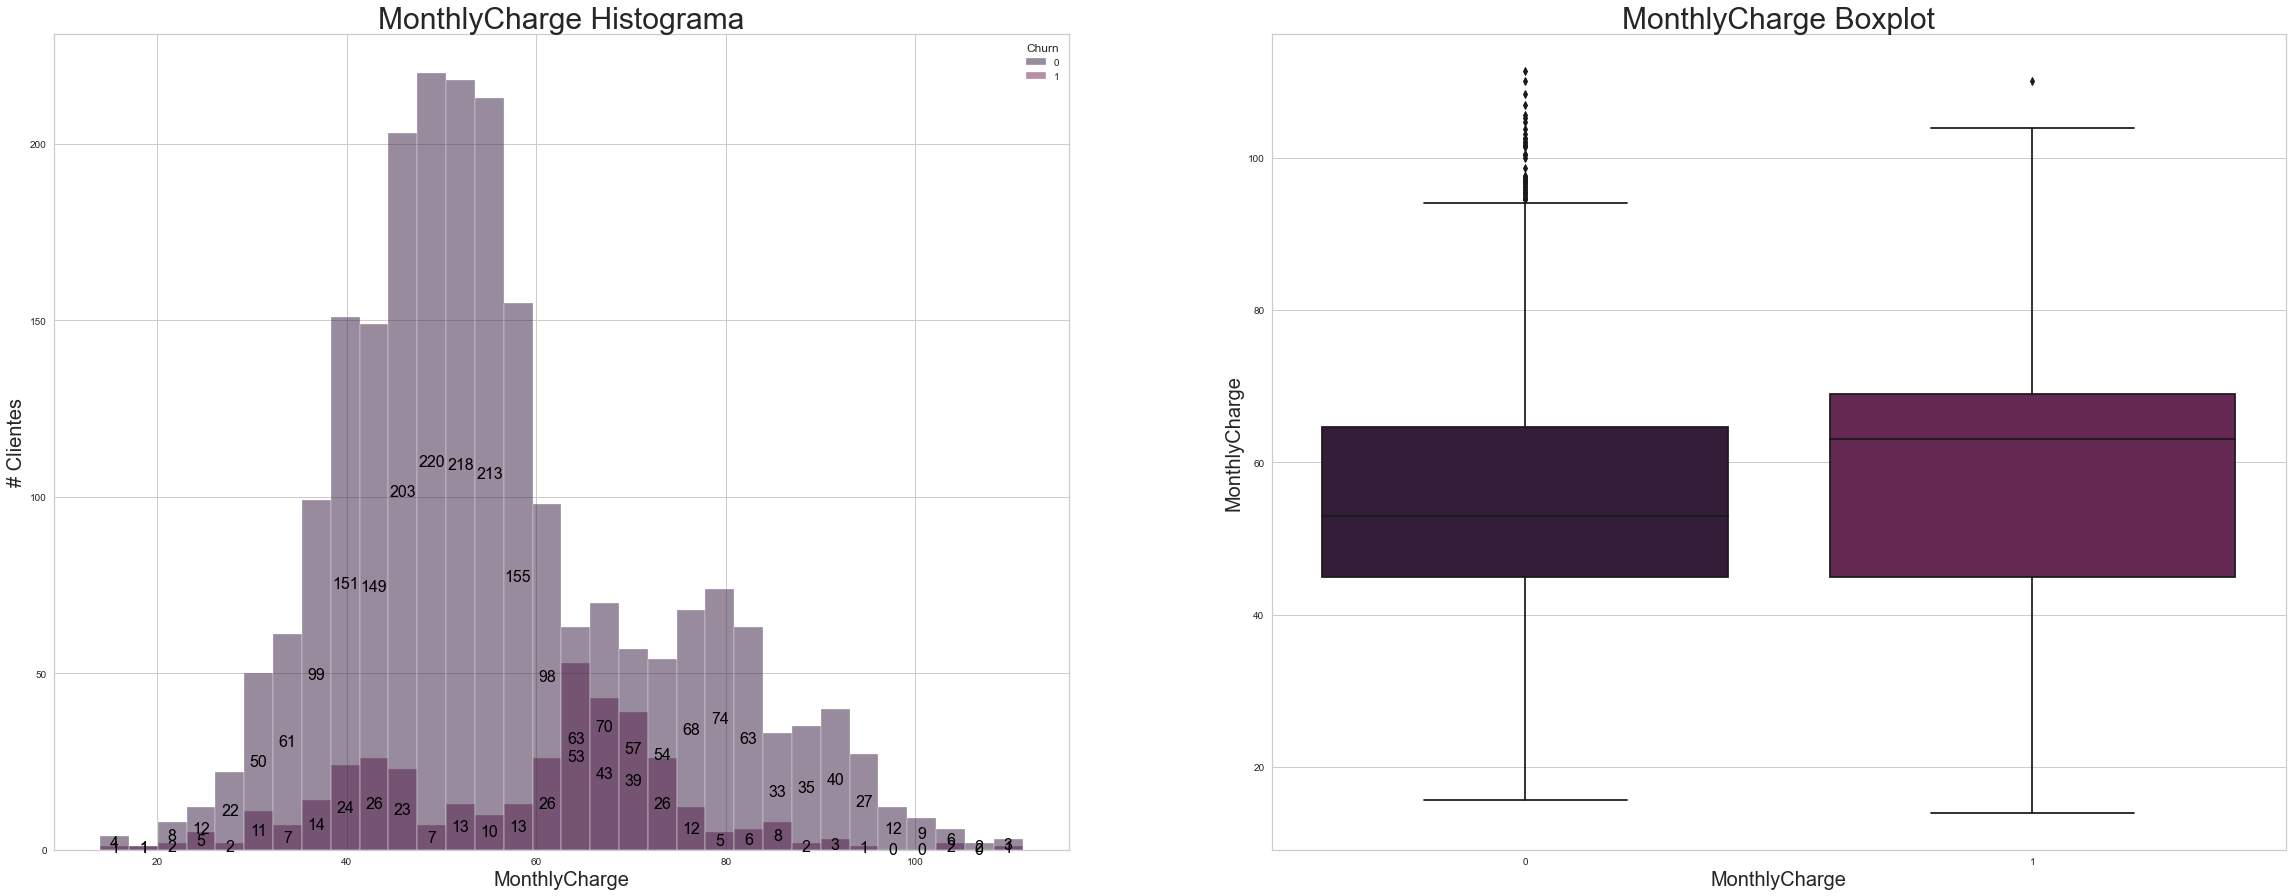

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(40, 15))

ax1 = sns.histplot(data = train_ds, x = 'MonthlyCharge', hue = "Churn", ax=axs[0])
ax1.set_title('MonthlyCharge Histograma', fontsize=30)
ax1.set_xlabel('MonthlyCharge', fontsize=20)
ax1.set_ylabel('# Clientes', fontsize=20)
ax1.ticklabel_format(style='plain', axis='y')
for p in ax1.patches:
    ax1.annotate('{0:,}'.format(p.get_height()), (p.get_x()+p.get_width()/2, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=16)

ax2 = sns.boxplot(x="Churn", y="MonthlyCharge", data=train_ds, ax=axs[1])
ax2.set_title('MonthlyCharge Boxplot', fontsize=30)
ax2.set_xlabel('MonthlyCharge', fontsize=20)
ax2.set_ylabel('MonthlyCharge', fontsize=20)
ax2.ticklabel_format(style='plain', axis='y')

### OverageFee 

In [28]:
#OverageFee - largest overage fee in last 12 months

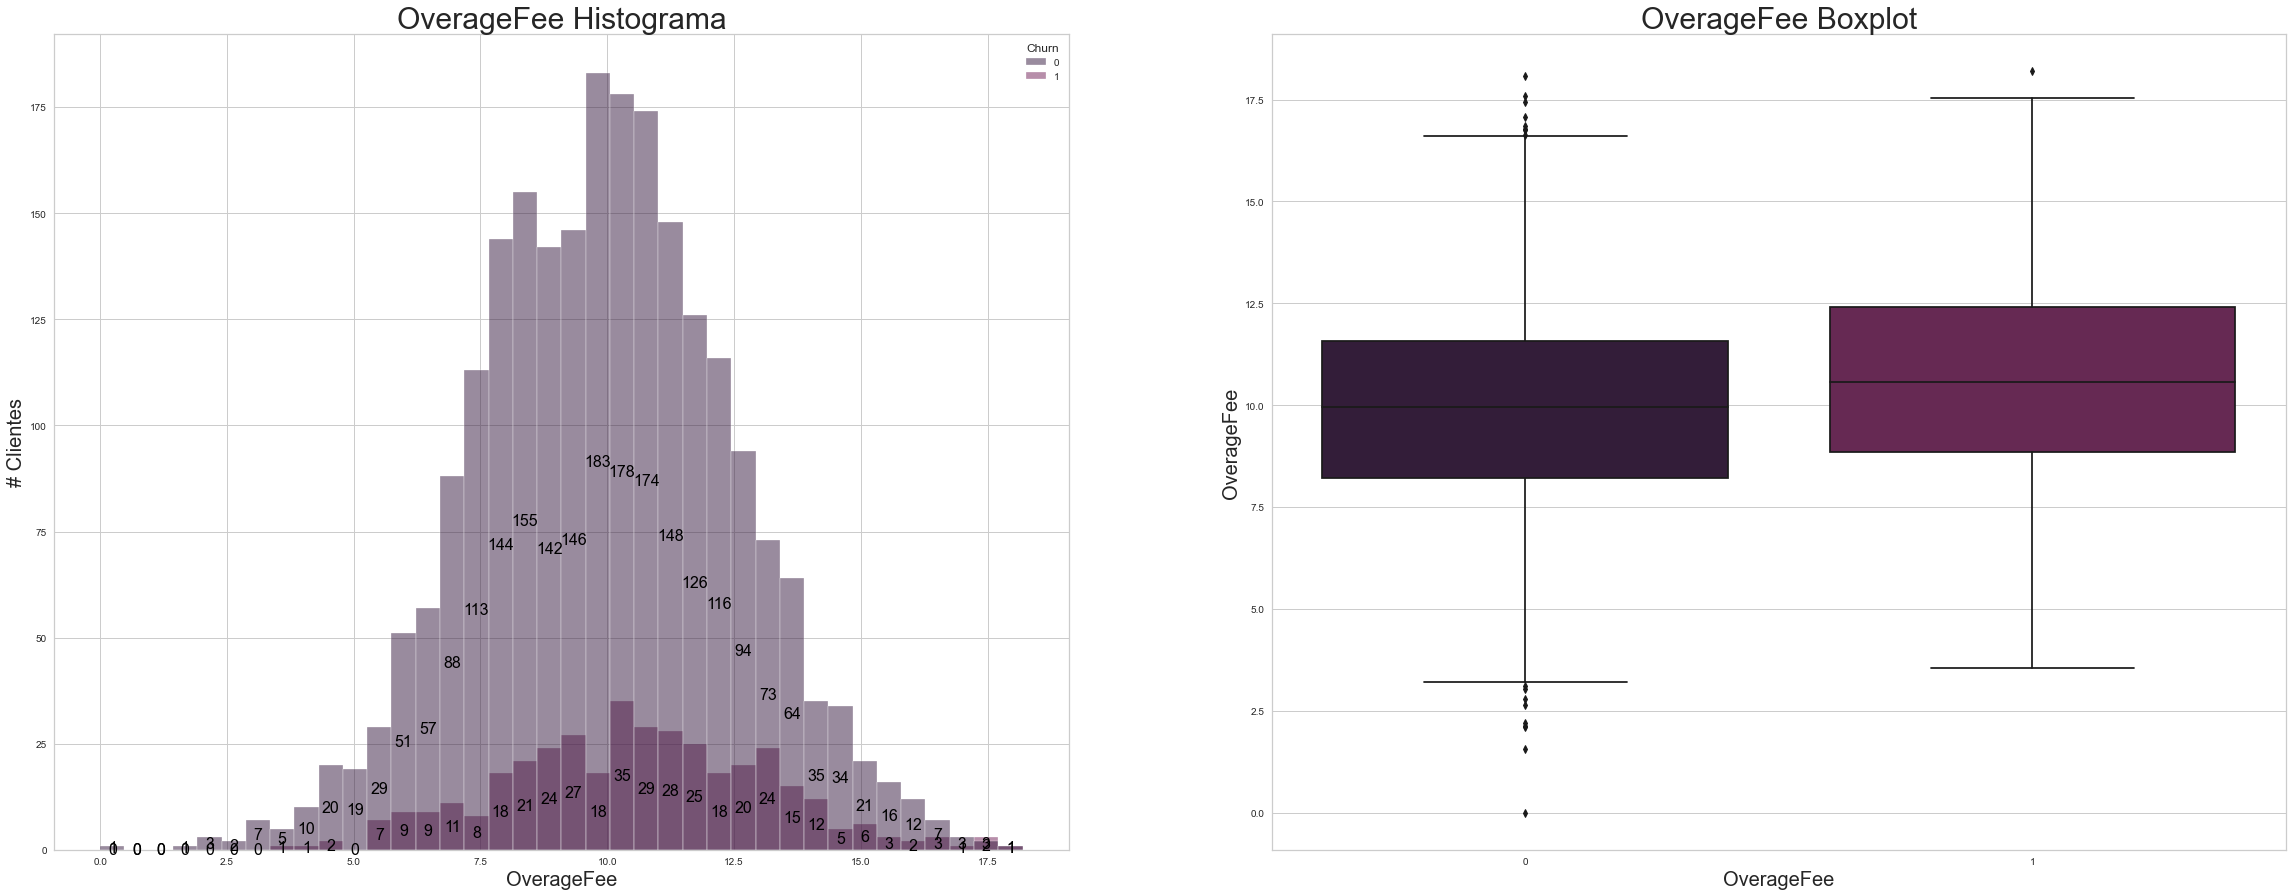

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(40, 15))

ax1 = sns.histplot(data = train_ds, x = 'OverageFee', hue = "Churn", ax=axs[0])
ax1.set_title('OverageFee Histograma', fontsize=30)
ax1.set_xlabel('OverageFee', fontsize=20)
ax1.set_ylabel('# Clientes', fontsize=20)
ax1.ticklabel_format(style='plain', axis='y')
for p in ax1.patches:
    ax1.annotate('{0:,}'.format(p.get_height()), (p.get_x()+p.get_width()/2, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=16)

ax2 = sns.boxplot(x="Churn", y="OverageFee", data=train_ds, ax=axs[1])
ax2.set_title('OverageFee Boxplot', fontsize=30)
ax2.set_xlabel('OverageFee', fontsize=20)
ax2.set_ylabel('OverageFee', fontsize=20)
ax2.ticklabel_format(style='plain', axis='y')

### RoamMins 

In [30]:
#RoamMins - average number of roaming minutes

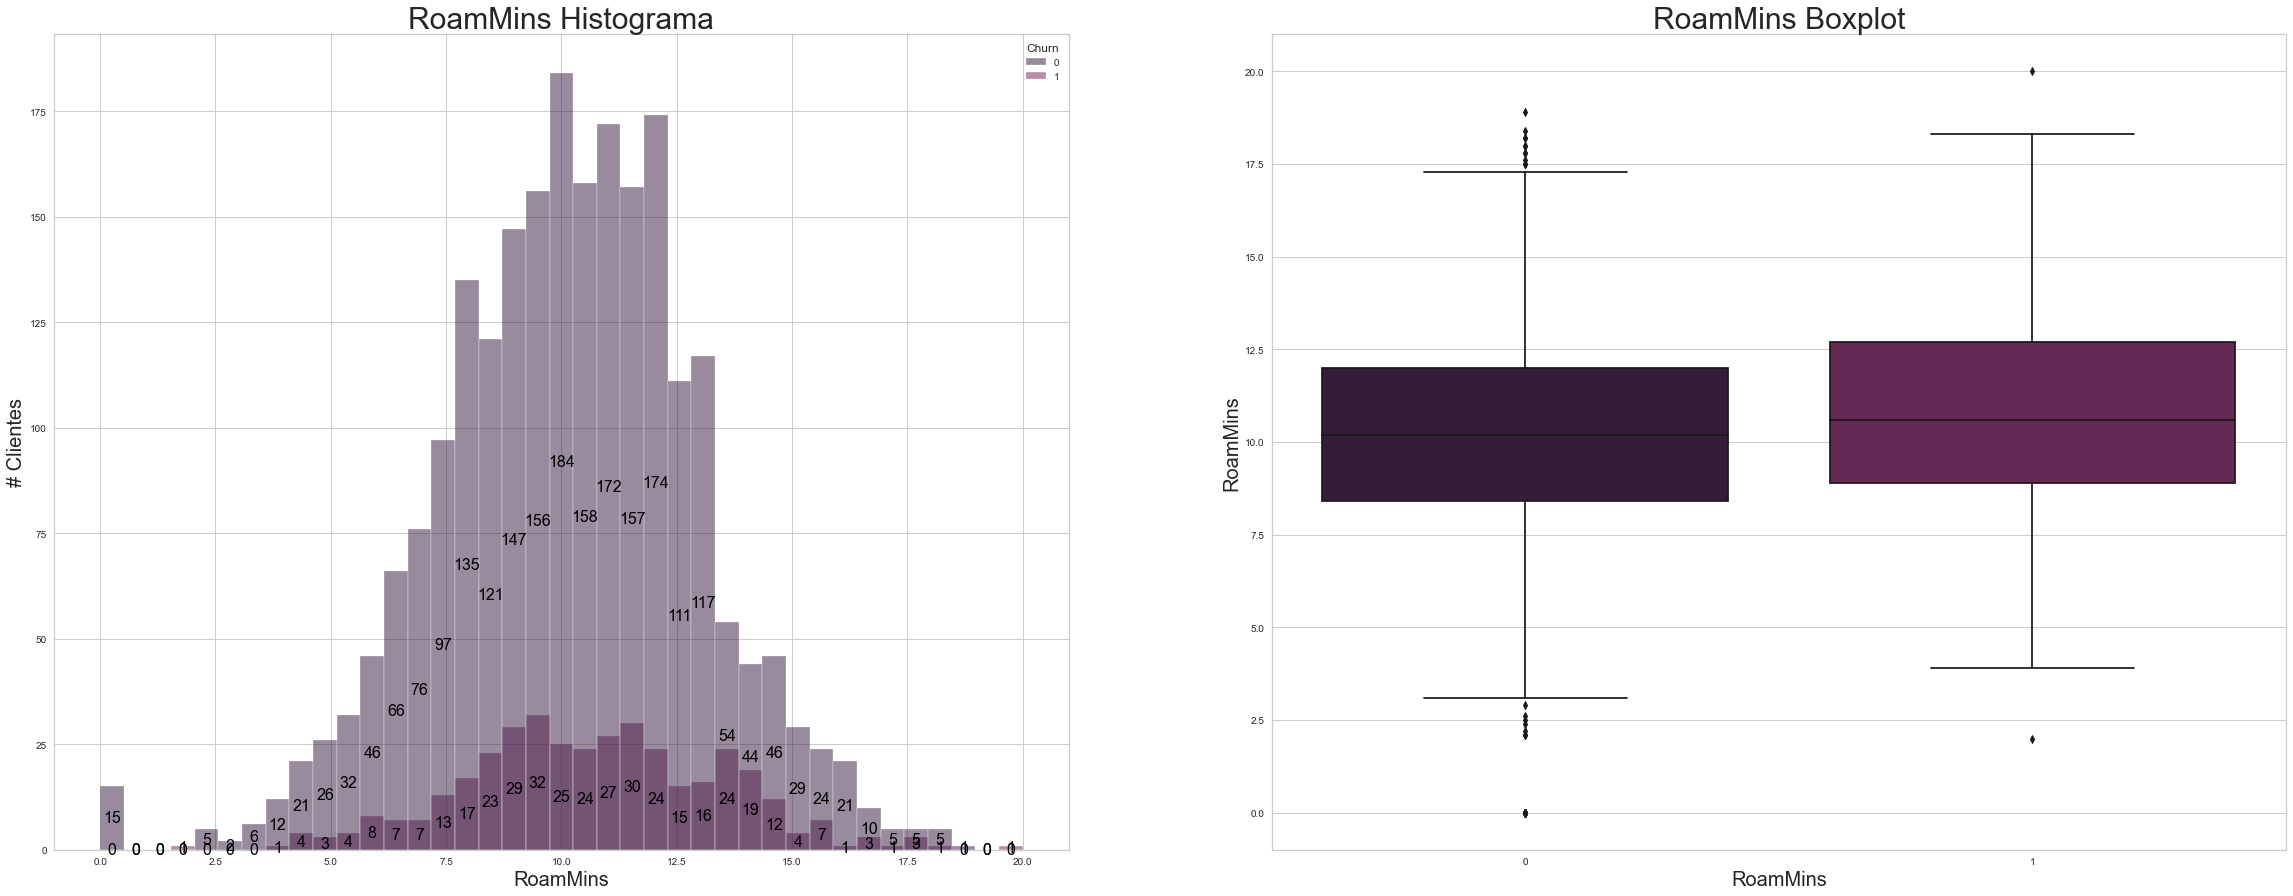

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(40, 15))

ax1 = sns.histplot(data = train_ds, x = 'RoamMins', hue = "Churn", ax=axs[0])
ax1.set_title('RoamMins Histograma', fontsize=30)
ax1.set_xlabel('RoamMins', fontsize=20)
ax1.set_ylabel('# Clientes', fontsize=20)
ax1.ticklabel_format(style='plain', axis='y')
for p in ax1.patches:
    ax1.annotate('{0:,}'.format(p.get_height()), (p.get_x()+p.get_width()/2, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=16)

ax2 = sns.boxplot(x="Churn", y="RoamMins", data=train_ds, ax=axs[1])
ax2.set_title('RoamMins Boxplot', fontsize=30)
ax2.set_xlabel('RoamMins', fontsize=20)
ax2.set_ylabel('RoamMins', fontsize=20)
ax2.ticklabel_format(style='plain', axis='y')

## 5.2 - Variáveis Categóricas

### ContractRenewal

In [32]:
#ContractRenewal - 1 if customer recently renewed contract, 0 if not

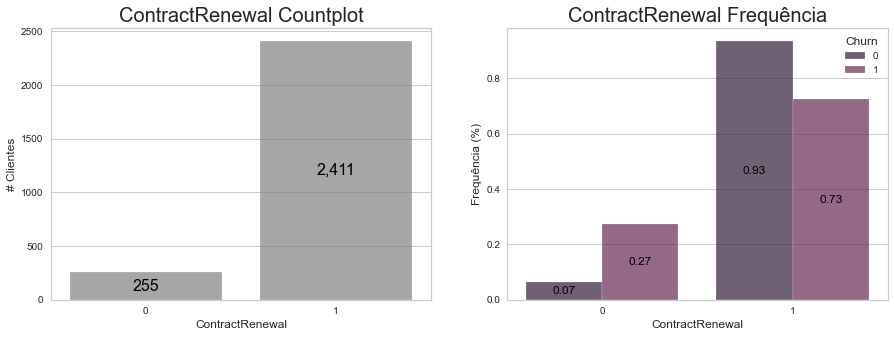

In [33]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

ax1 = sns.countplot(data=train_ds, x="ContractRenewal", ax=axs[0], alpha=0.7, palette=['grey'])
ax1.set_title('ContractRenewal Countplot', fontsize=20)
ax1.set_xlabel('ContractRenewal', fontsize=12)
ax1.set_ylabel('# Clientes', fontsize=12)
ax1.ticklabel_format(style='plain', axis='y')
for p in ax1.patches:
    ax1.annotate('{0:,}'.format(p.get_height()), (p.get_x()+0.4, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=16)

pct2 = (train_ds.groupby(['ContractRenewal','Churn']).size() / train_ds.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax2 = sns.barplot(x='ContractRenewal', hue='Churn', y='Frequência', data=pct2, alpha=0.7, ax=axs[1])
ax2.set_title('ContractRenewal Frequência', fontsize=20)
ax2.set_xlabel('ContractRenewal', fontsize=12)
ax2.set_ylabel('Frequência (%)', fontsize=12)
ax2.ticklabel_format(style='plain', axis='y')
for p in ax2.patches:
    ax2.annotate('{0:,.2f}'.format(p.get_height()), (p.get_x()+0.2, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=12)

### DataPlan

In [34]:
#DataPlan - 1 if customer has data plan, 0 if not

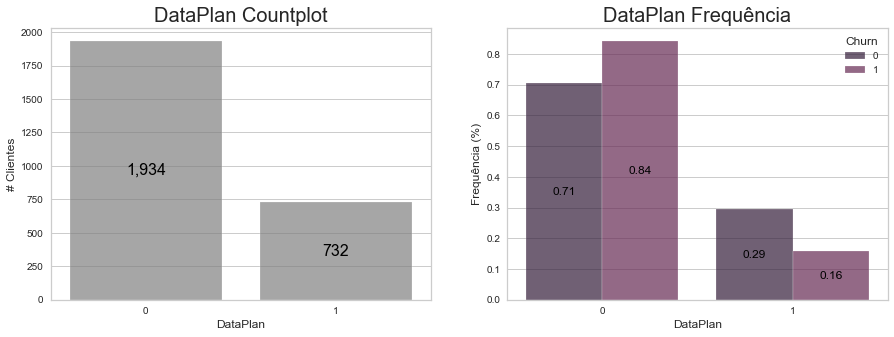

In [35]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

ax1 = sns.countplot(data=train_ds, x="DataPlan", ax=axs[0], alpha=0.7, palette=['grey'])
ax1.set_title('DataPlan Countplot', fontsize=20)
ax1.set_xlabel('DataPlan', fontsize=12)
ax1.set_ylabel('# Clientes', fontsize=12)
ax1.ticklabel_format(style='plain', axis='y')
for p in ax1.patches:
    ax1.annotate('{0:,}'.format(p.get_height()), (p.get_x()+0.4, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=16)

pct2 = (train_ds.groupby(['DataPlan','Churn']).size() / train_ds.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax2 = sns.barplot(x='DataPlan', hue='Churn', y='Frequência', data=pct2, alpha=0.7, ax=axs[1])
ax2.set_title('DataPlan Frequência', fontsize=20)
ax2.set_xlabel('DataPlan', fontsize=12)
ax2.set_ylabel('Frequência (%)', fontsize=12)
ax2.ticklabel_format(style='plain', axis='y')
for p in ax2.patches:
    ax2.annotate('{0:,.2f}'.format(p.get_height()), (p.get_x()+0.2, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=12)

### CustServCalls 

In [36]:
#CustSurvCalls - number of calls into customer service

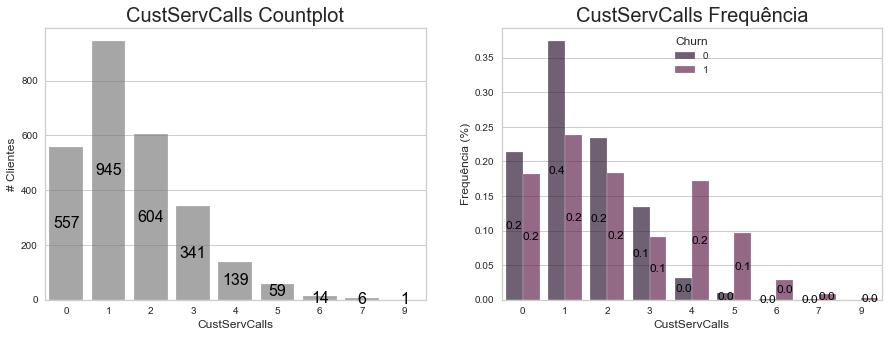

In [37]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

ax1 = sns.countplot(data=train_ds, x="CustServCalls", ax=axs[0], alpha=0.7, palette=['grey'])
ax1.set_title('CustServCalls Countplot', fontsize=20)
ax1.set_xlabel('CustServCalls', fontsize=12)
ax1.set_ylabel('# Clientes', fontsize=12)
ax1.ticklabel_format(style='plain', axis='y')
for p in ax1.patches:
    ax1.annotate('{0:,}'.format(p.get_height()), (p.get_x()+0.4, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=16)

pct2 = (train_ds.groupby(['CustServCalls','Churn']).size() / train_ds.groupby(['Churn']).size()).reset_index().rename({0:'Frequência'}, axis=1)
ax2 = sns.barplot(x='CustServCalls', hue='Churn', y='Frequência', data=pct2, alpha=0.7, ax=axs[1])
ax2.set_title('CustServCalls Frequência', fontsize=20)
ax2.set_xlabel('CustServCalls', fontsize=12)
ax2.set_ylabel('Frequência (%)', fontsize=12)
ax2.ticklabel_format(style='plain', axis='y')
for p in ax2.patches:
    ax2.annotate('{0:,.1f}'.format(p.get_height()), (p.get_x()+0.2, 
                                                  (p.get_height()/2)), ha='center', va='center', color='black', size=12)

## 5.3 - Análise de Correlação 

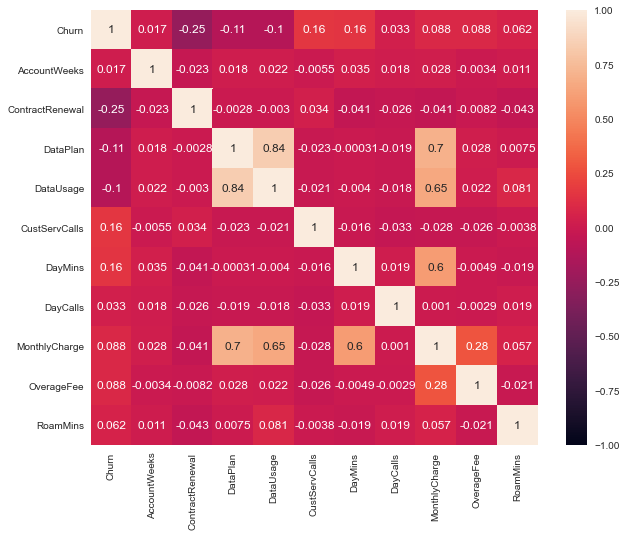

In [38]:
#Plotando Correlação com método spearman

plt.figure(figsize=(10,8))
sns.heatmap(train_ds.corr(method = 'spearman'), vmin=-1, vmax=1, annot=train_ds.corr(method = 'spearman'))
plt.show()

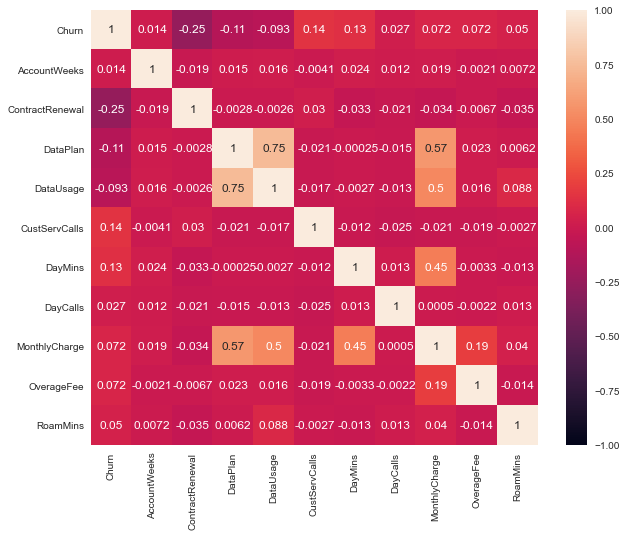

In [39]:
#Plotando Correlação com método kendall

plt.figure(figsize=(10,8))
sns.heatmap(train_ds.corr(method = 'kendall'), vmin=-1, vmax=1, annot=train_ds.corr(method = 'kendall'))
plt.show()

## 5.4 - Análise Bivariada 

### CustServCalls X  DayMins

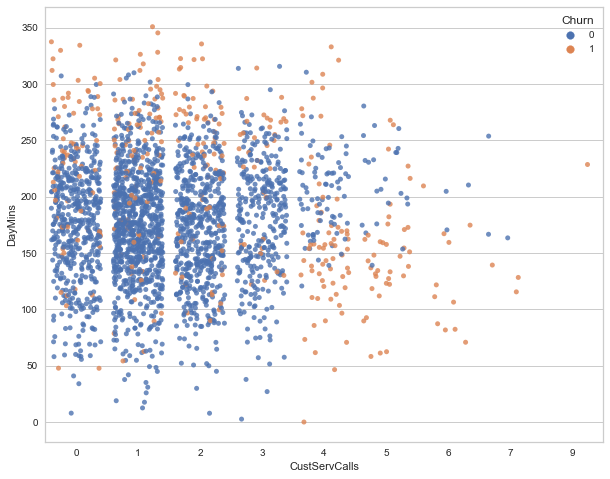

In [40]:
plt.figure(figsize=(10,8))
sns.stripplot(x="CustServCalls", y="DayMins", hue="Churn", data=train_ds, alpha=0.8, jitter=.4, palette="deep")

### ContractRenewal X  DayMins

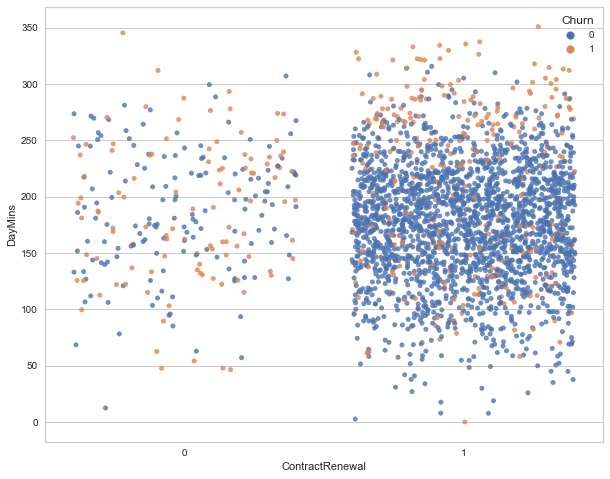

In [41]:
plt.figure(figsize=(10,8))
sns.stripplot(x="ContractRenewal", y="DayMins", hue="Churn", data=train_ds, alpha=0.8, jitter=.4, palette="deep")

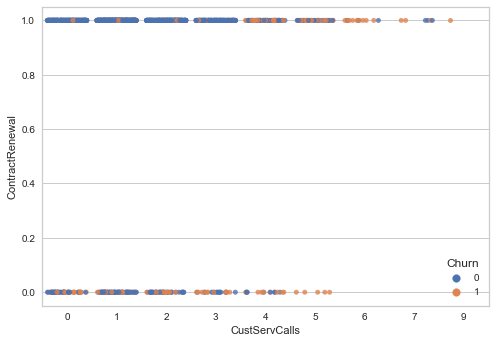

In [42]:
sns.stripplot(x="CustServCalls", y="ContractRenewal", hue="Churn", data=train_ds, alpha=0.8, jitter=.4, palette="deep")

## 5.5 - Separação em X e y 

In [43]:
#Definindo X e Y para treino e teste

X_train = train_ds.drop("Churn", axis=1)
X_train = X_train.reset_index(drop=True)

y_train = train_ds["Churn"].copy()
y_train= y_train.reset_index(drop=True)

X_test = test_ds.drop("Churn", axis=1)
X_test = X_test.reset_index(drop=True)

y_test = test_ds["Churn"].copy()
y_test = y_test.reset_index(drop=True)

In [44]:
#Verificando shape das bases

print("Shape X_train") 
print(X_train.shape)
print("Shape X_test") 
print(X_test.shape)
print("Shape y_train") 
print(y_train.shape)
print("Shape y_test") 
print(y_test.shape)

Shape X_train
(2666, 10)
Shape X_test
(667, 10)
Shape y_train
(2666,)
Shape y_test
(667,)


In [45]:
#Criando copia das bases

X_train_copy=X_train.copy()

X_test_copy=X_test.copy()

y_train_copy=y_train.copy()

y_test_copy=y_test.copy()

## 5.6 - Treinando e Avaliando Árvore de Decisão

In [46]:
# Treinando árvore de decisão para identificar feature_importance e obter insights a partir da árvore

dt_clf = tree.DecisionTreeClassifier(max_depth=3)

dt_clf = dt_clf.fit(X_train_copy, y_train_copy)

y_predict = dt_clf.predict(X_test_copy)

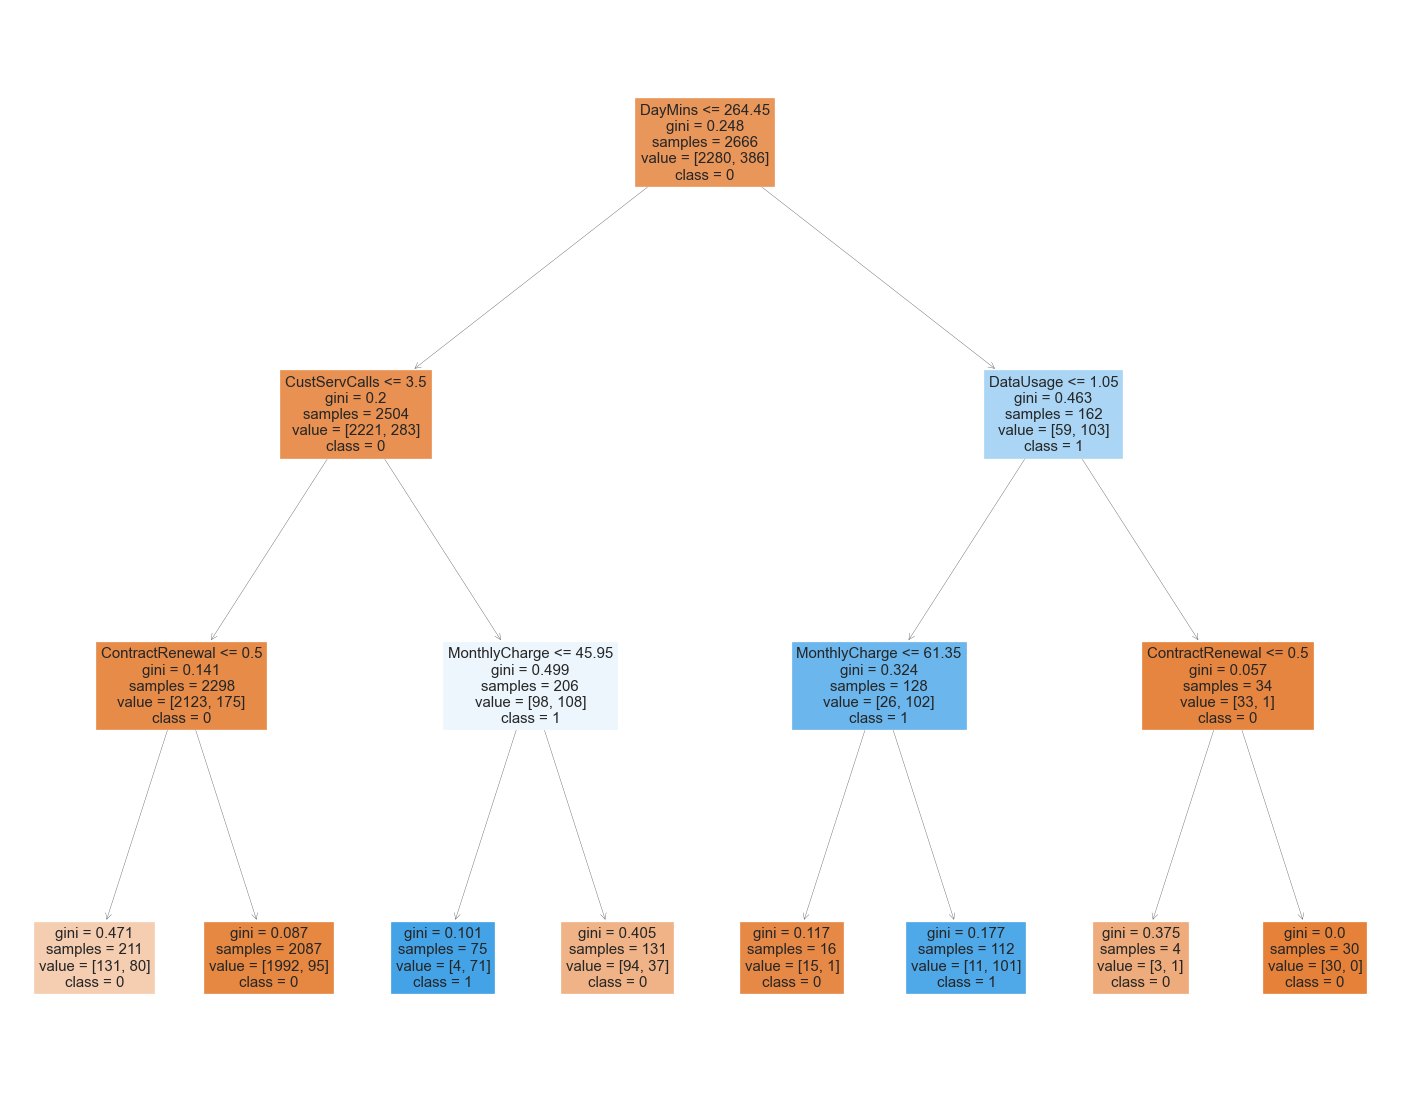

In [47]:
target_names=[]
for i in dt_clf.classes_:
    target_names.append(str(i))

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_clf, 
                   feature_names=dt_clf.feature_names_in_,  
                   class_names=target_names,
                   filled=True)

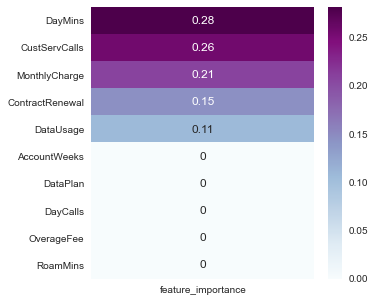

In [48]:
#Verificando importância das variáveis

fig, axs = plt.subplots(figsize=(5, 5))

feature_importance_df=pd.DataFrame(index=dt_clf.feature_names_in_,
                                   data={'feature_importance': dt_clf.feature_importances_}).sort_values(by="feature_importance",
                                                                                                         ascending =False )

sns.heatmap(feature_importance_df, annot=True, cmap="BuPu")


Done in 0.732878 s  
 



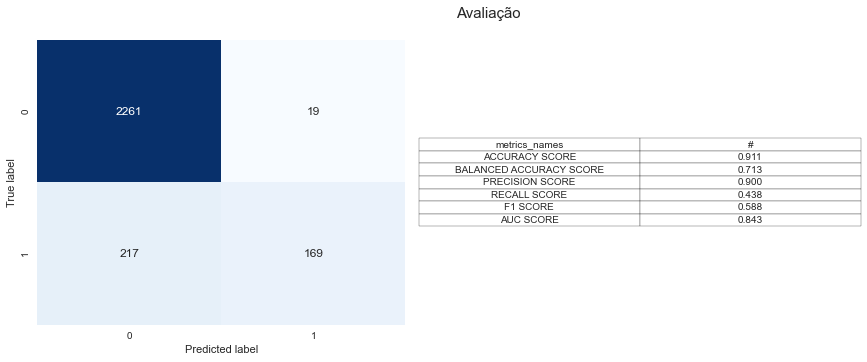

In [49]:
#Verificando métricas no treino com cross validation

analisa_metricas_cross_val(dt_clf, X_train_copy, y_train_copy, n_folds=5)


Done in 0.921569 s  
 



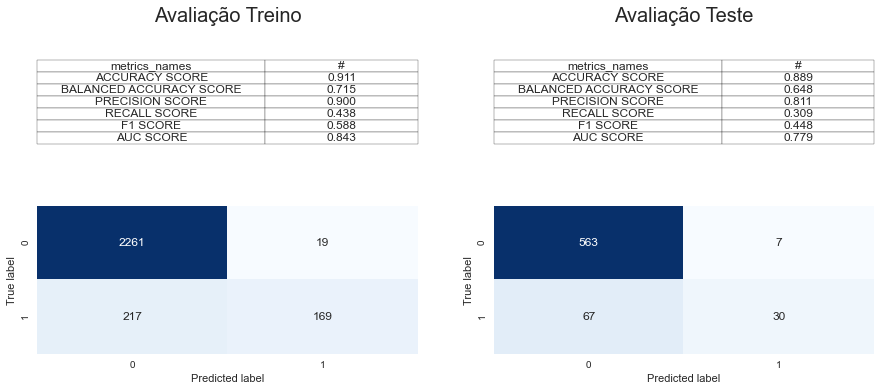

In [50]:
#Verificando métricas no treino com cross validation e no teste

analisa_metricas_treino_teste(dt_clf, X_train_copy, y_train_copy, X_test_copy, y_test_copy, n_folds=5)

## 6 - Pré Processamento 

## 6.1 - Padronização dos Dados 

In [51]:
# Separando dados numéricos para padronização

X_train_copy_num = X_train_copy[["AccountWeeks", "DataUsage", "DayMins", "DayCalls",
                                            "MonthlyCharge", "OverageFee", "RoamMins", "CustServCalls"]]

X_test_copy_num = X_test_copy[["AccountWeeks", "DataUsage", "DayMins", "DayCalls",
                                            "MonthlyCharge", "OverageFee", "RoamMins", "CustServCalls"]]

X_train_copy_cat = X_train_copy[["ContractRenewal", "DataPlan"]]
X_test_copy_cat = X_test_copy[["ContractRenewal", "DataPlan"]]

In [52]:
# Padronizando dados numericos

scaler = StandardScaler().fit(X_train_copy_num)

X_train_copy_num_tr = scaler.transform(X_train_copy_num)
X_test_copy_num_tr = scaler.transform(X_test_copy_num)

X_train_copy_num_tr = pd.DataFrame(X_train_copy_num_tr, columns = X_train_copy_num.columns)
X_test_copy_num_tr = pd.DataFrame(X_test_copy_num_tr, columns = X_test_copy_num.columns)

In [53]:
#Concatenando as bases de treino

X_train_copy_v2 = pd.concat([X_train_copy_num_tr, X_train_copy_cat], axis = 1)
X_train_copy_v2.head()

,AccountWeeks,DataUsage,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,CustServCalls,ContractRenewal,DataPlan
0,0.125737,2.135617,0.743376,0.225611,2.207654,0.425294,1.018565,-1.200212,1,1
1,-0.175309,-0.638714,-0.401294,0.225611,-0.931798,-0.905919,-0.800731,1.875007,1,0
2,-0.752313,0.544687,-0.704945,0.325566,-0.192744,-0.747441,-1.656870,0.337397,1,1
3,0.727828,-0.638714,-2.048368,-0.723960,-1.664744,-0.145226,0.055409,-1.200212,1,0
4,-0.350919,-0.309556,0.800425,0.425520,-0.186636,-1.448705,1.517980,1.106202,1,0


In [54]:
#Concatenando as bases de teste

X_test_copy_v2 = pd.concat([X_test_copy_num_tr, X_test_copy_cat], axis = 1)

In [55]:
#Verificando shape das bases

print("Shape X_train") 
print(X_train_copy_v2.shape)
print("Shape X_test") 
print(X_test_copy_v2.shape)
print("Shape y_train") 
print(y_train_copy.shape)
print("Shape y_test")
print(y_test_copy.shape)

Shape X_train
(2666, 10)
Shape X_test
(667, 10)
Shape y_train
(2666,)
Shape y_test
(667,)


## 6.2 - Utilizando Técnicas de Resample

In [56]:
# Realizando Oversampling com SMOTE
smote = SMOTE(random_state=seed)
X_resample_smote, y_resample_smote = smote.fit_resample(X_train_copy_v2, y_train_copy)

# Realizando Oversampling com RandomOverSampler
ros = RandomOverSampler(random_state=seed)
X_resample_ros, y_resample_ros = ros.fit_resample(X_train_copy_v2, y_train_copy)

# Realizando Undersampling com RandomUnderSampler
rus = RandomUnderSampler(random_state=seed)
X_resample_rus, y_resample_rus = rus.fit_resample(X_train_copy_v2, y_train_copy)

In [57]:
#Verificando Shape

print("Shape X_resample_smote") 
print(X_resample_smote.shape)
print("Shape y_resample_smote") 
print(y_resample_smote.shape)

print("Shape X_resample_ros") 
print(X_resample_ros.shape)
print("Shape y_resample_ros")
print(y_resample_ros.shape)

print("Shape X_resample_rus") 
print(X_resample_rus.shape)
print("Shape y_resample_rus")
print(y_resample_rus.shape)

Shape X_resample_smote
(4560, 10)
Shape y_resample_smote
(4560,)
Shape X_resample_ros
(4560, 10)
Shape y_resample_ros
(4560,)
Shape X_resample_rus
(772, 10)
Shape y_resample_rus
(772,)


In [58]:
#Verificando que classes agora estão balanceadas

pd.DataFrame(data={"SMOTE": list(y_resample_smote.value_counts()), "ROS": list(y_resample_ros.value_counts()),
                "RUS": list(y_resample_rus.value_counts())})

,SMOTE,ROS,RUS
0,2280,2280,386
1,2280,2280,386


In [59]:
# Reduzindo a dimensionalidade para verificar gráficos

pca_no_resample = PCA(n_components= 2).fit_transform(X_train_copy_v2)

pca_smote = PCA(n_components= 2).fit_transform(X_resample_smote)

pca_ros = PCA(n_components= 2).fit_transform(X_resample_ros)

pca_rus = PCA(n_components= 2).fit_transform(X_resample_rus)

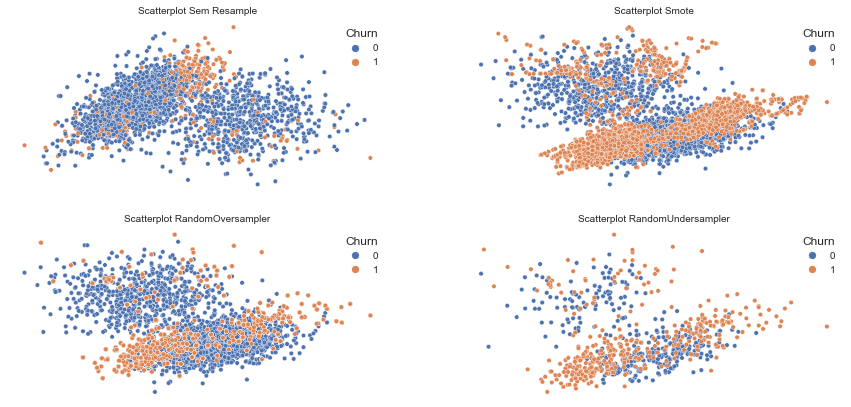

In [60]:
# Plotando gráficos Scatterplot para obter insights a respeito de qual método de resampling irá produzir melhores resultados

fig, axs = plt.subplots(2, 2, figsize=(15, 7))

ax1= sns.scatterplot(x=pca_no_resample[:,0], y=pca_no_resample[:,1],hue=y_train_copy, ax=axs[0][0], s=20, palette="deep")
ax1.set_title('Scatterplot Sem Resample', fontsize=10)
ax1.axis('off')

ax2= sns.scatterplot(x=pca_smote[:,0], y=pca_smote[:,1],hue=y_resample_smote, ax=axs[0][1], s=20, palette="deep")
ax2.set_title('Scatterplot Smote', fontsize=10)
ax2.axis('off')

ax3= sns.scatterplot(x=pca_ros[:,0], y=pca_ros[:,1],hue=y_resample_ros, ax=axs[1][0], s=20, palette="deep")
ax3.set_title('Scatterplot RandomOversampler', fontsize=10)
ax3.axis('off')

ax4= sns.scatterplot(x=pca_rus[:,0], y=pca_rus[:,1],hue=y_resample_rus, ax=axs[1][1], s=20, palette="deep")
ax4.set_title('Scatterplot RandomUndersampler', fontsize=10)
ax4.axis('off')

plt.show()

## 7 - Escolha de Métricas para Avaliação de Modelos

Para avaliação dos modelos adotados partiremos das seguintes ações e premissas:
Possíveis Ações:
	Ação A - (Cliente previsto como Churn=1 pelo modelo): Oferecer pacote de benefícios e consultoria especial, dando maior atenção ao cliente, como forma de estratégia para que cliente cancele o plano com a empresa.
	Ação B - (Cliente previsto como Churn=0 pelo modelo): Não entrar em contato com cliente.
Premissas:
	Premissa 1: Caso cliente cancele o produto, empresa deixará de ter a receita pelos n meses subsequentes
	Premissa 2: Custo de saída da empresa>>Custo de Pacote de benefícios + Consultoria especial.
Dessa forma, de acordo com as premissas e possíveis ações estabelecidas, adotaremos o recall como a principal métrica a ser avaliada, priorizando assim, a redução de falsos negativos em detrimento do aumento de falsos positivos. Apesar disso, é importante a análise de outras métricas em conjunto com o recall, como a acuraria e o F1 score, de forma a ter maior qualidade no modelo.

## 8 - Treinando e Avaliando Modelos de Machine Learning

## 8.1 - Avaliação Inicial de Modelos 

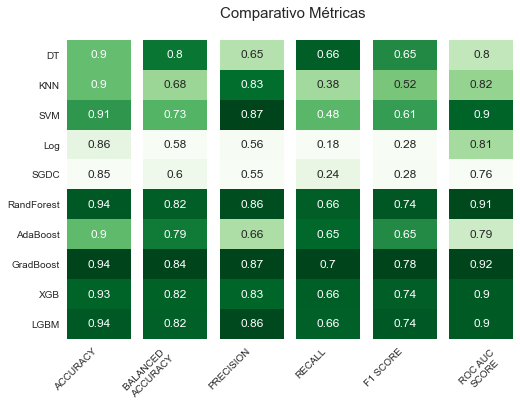


Done in 59.992004 s  
 



In [61]:
#Treinando modelos com base sem Resemple e avaliando com crossvalidation

clf_dict={'DT': DecisionTreeClassifier(random_state=seed),
          'KNN': KNeighborsClassifier(n_jobs=-1),
          'SVM': SVC(random_state=seed),
          'Log': LogisticRegression(random_state=seed, n_jobs=-1),
          'SGDC': SGDClassifier(random_state=seed, n_jobs=-1),
          'RandForest': RandomForestClassifier(random_state=seed, n_jobs=-1),
          'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(), random_state=seed),
          'GradBoost': GradientBoostingClassifier(random_state=seed),
          'XGB': XGBClassifier(random_state=seed, use_label_encoder=False, verbosity = 0),
          'LGBM': LGBMClassifier(random_state=seed, n_jobs=-1)
         }

treina_avalia_compara(clf_dict, X_train_copy_v2, y_train, n_folds=5)

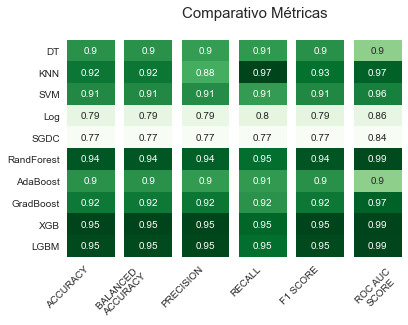


Done in 90.611839 s  
 



In [158]:
#Treinando modelos com base com SMOTE e avaliando com crossvalidation

treina_avalia_compara(clf_dict, X_resample_smote, y_resample_smote, n_folds=5)

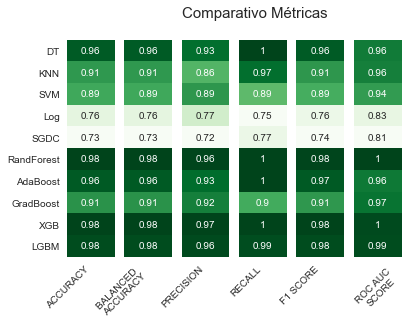


Done in 85.776144 s  
 



In [159]:
#Treinando modelos com base com RandomOverSampler e avaliando com crossvalidation

treina_avalia_compara(clf_dict, X_resample_ros, y_resample_ros, n_folds=5)

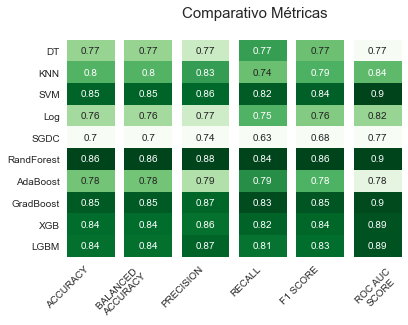


Done in 29.053502 s  
 



In [160]:
#Treinando modelos com base com RandomUnderSampler e avaliando com crossvalidation

treina_avalia_compara(clf_dict, X_resample_rus, y_resample_rus, n_folds=5)

## 8.2 - Comparativo de Bases Utilizadas (Overfit)

### GradBoost 


Done in 19.170729 s  
 



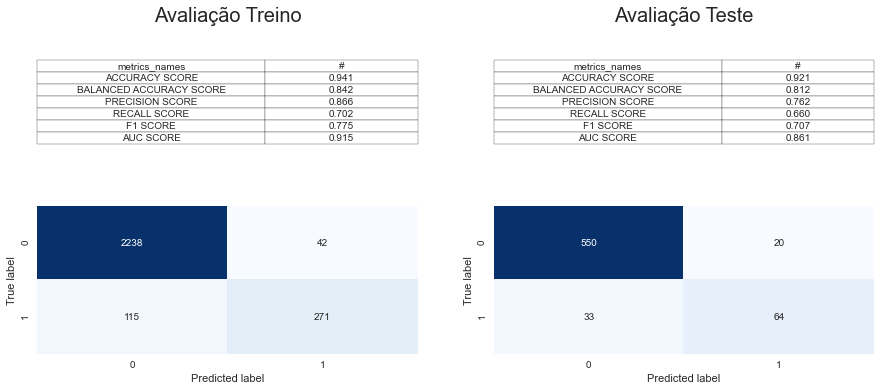

In [166]:
#Sem Resample

gra_clf=clf_dict["GradBoost"]

gra_clf = gra_clf.fit(X_train_copy_v2, y_train_copy)

analisa_metricas_treino_teste(gra_clf,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)


Done in 36.766829 s  
 



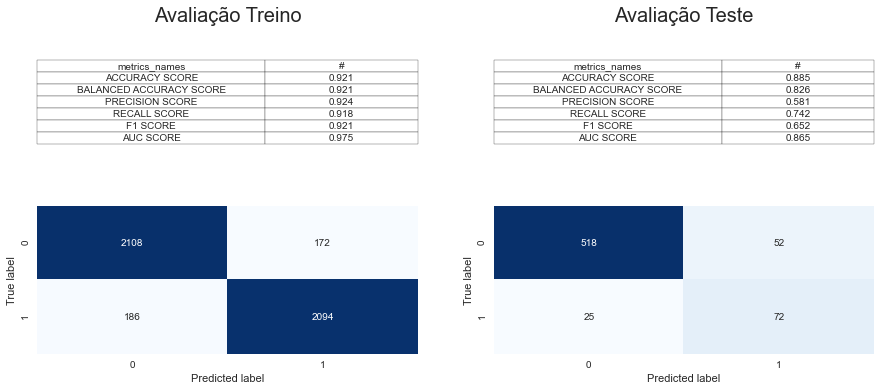

In [170]:
#Com Resample

gra_clf = gra_clf.fit(X_resample_smote, y_resample_smote)

analisa_metricas_treino_teste(gra_clf,
                              X_resample_smote, y_resample_smote, X_test_copy_v2, y_test_copy, n_folds=5)

### Random Forest 


Done in 12.209774 s  
 



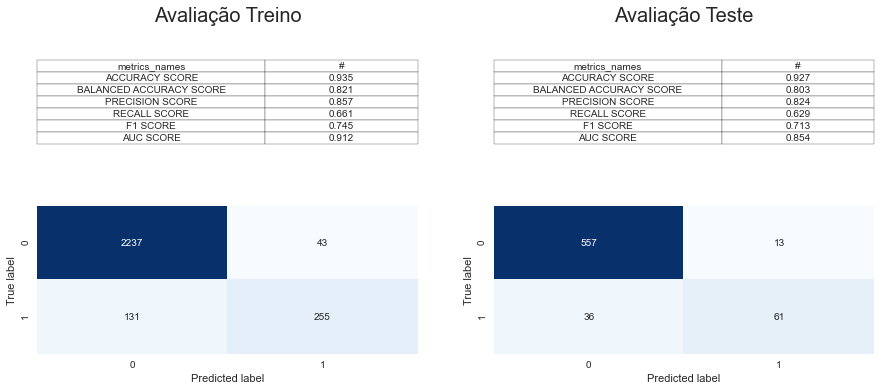

In [165]:
#Sem Resample

ran_clf=clf_dict["RandForest"]

ran_clf = ran_clf.fit(X_train_copy_v2, y_train_copy)

analisa_metricas_treino_teste(ran_clf,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)


Done in 17.822753 s  
 



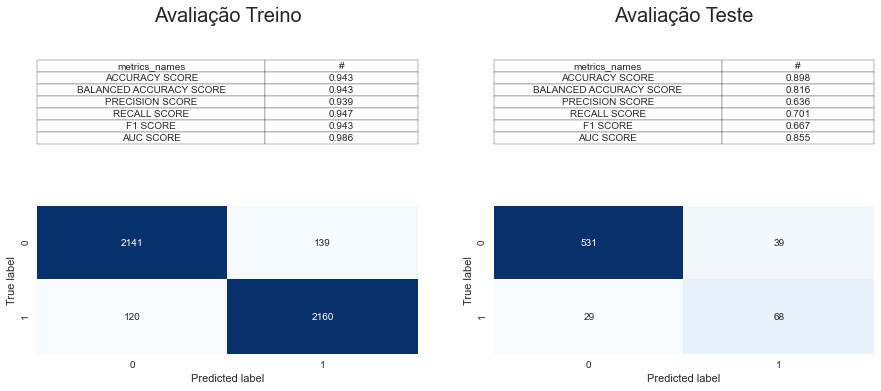

In [168]:
#Com Resample

ran_clf=clf_dict["RandForest"]

ran_clf = ran_clf.fit(X_resample_smote, y_resample_smote)

analisa_metricas_treino_teste(ran_clf,
                              X_resample_smote, y_resample_smote, X_test_copy_v2, y_test_copy, n_folds=5)

### XGBOOST


Done in 11.907223 s  
 



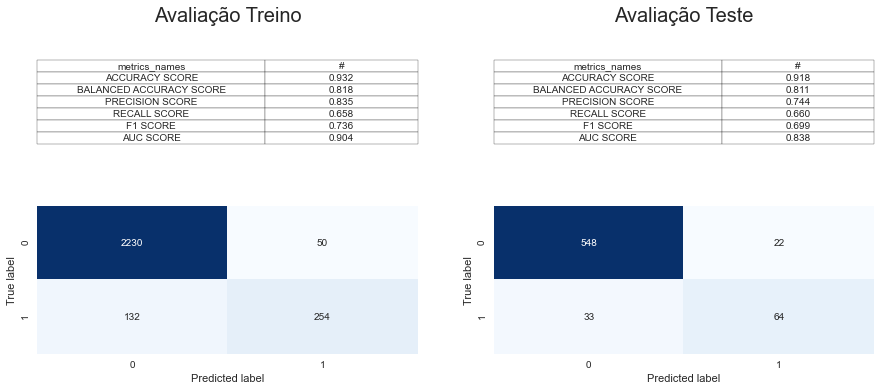

In [167]:
#Sem Resample

xgb_clf=clf_dict["XGB"]

xgb_clf = xgb_clf.fit(X_train_copy_v2, y_train_copy)

analisa_metricas_treino_teste(xgb_clf,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)


Done in 20.180056 s  
 



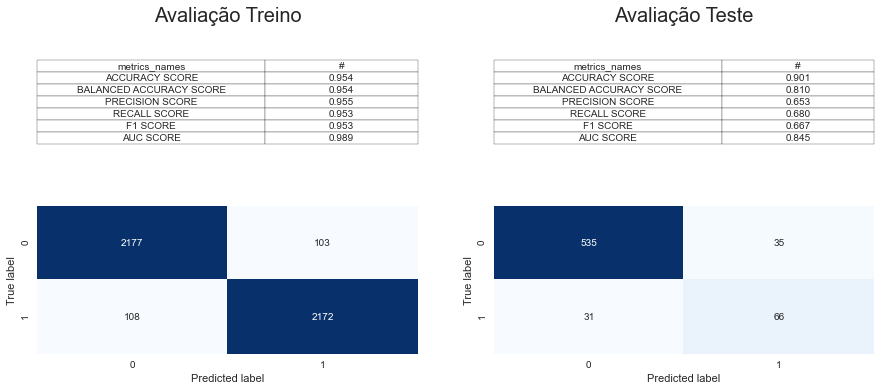

In [173]:
#Com Resample

xgb_clf = xgb_clf.fit(X_resample_smote, y_resample_smote)

analisa_metricas_treino_teste(xgb_clf,
                              X_resample_smote, y_resample_smote, X_test_copy_v2, y_test_copy, n_folds=5)

### LGBM 


Done in 8.775531 s  
 



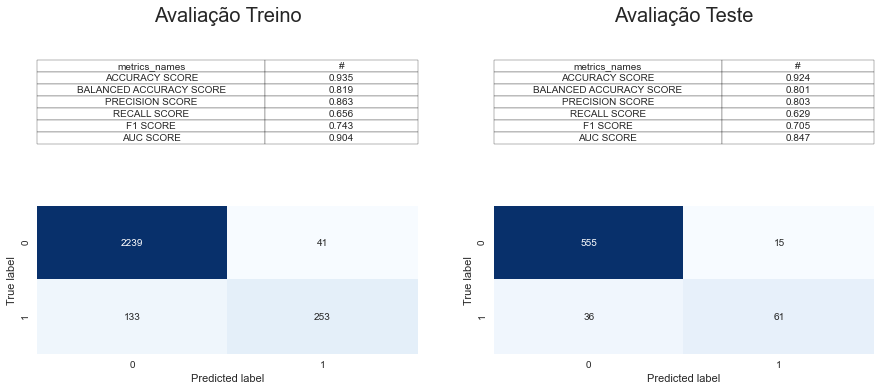

In [172]:
#Sem Resample

lgbm_clf=clf_dict["LGBM"]

lgbm_clf = lgbm_clf.fit(X_train_copy_v2, y_train_copy)

analisa_metricas_treino_teste(lgbm_clf,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)


Done in 10.656022 s  
 



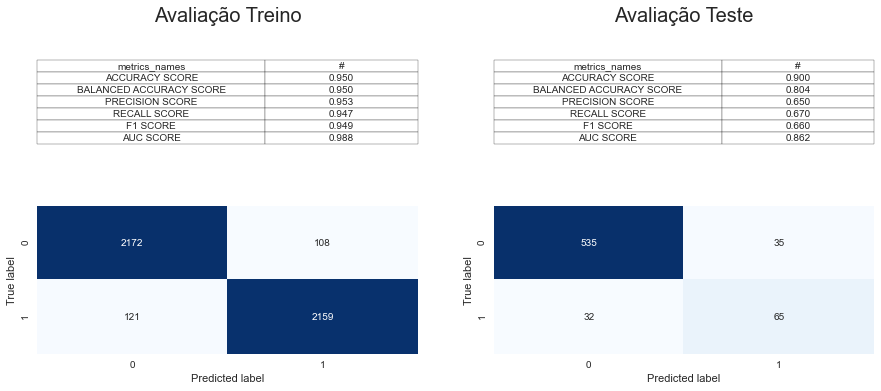

In [174]:
#Com Resample

lgbm_clf = lgbm_clf.fit(X_resample_smote, y_resample_smote)

analisa_metricas_treino_teste(lgbm_clf,
                              X_resample_smote, y_resample_smote, X_test_copy_v2, y_test_copy, n_folds=5)

In [ ]:
# Escolhi a base sem resample pois temos melhor acuracia e F1 score na base de teste e recall bem parecido.
# De qualquer forma, desempenho dos modelos nas duas bases é bem parecida

In [74]:
# Alternar hiperparametros para RandomForest, GradientBoost, XGBoost, LGBM pois obtiveram melhores resultados
# Também será avaliado SVM com diferentes kernels

In [75]:
erro proposital

SyntaxError: invalid syntax (<ipython-input-75-e38be8c05dab>, line 1)

## 9 - Avaliação e Seleção de Modelos Promissores

## 9.1 - GradientBoosting

### Gradient Boosting Melhores Parâmetros

In [82]:
gra_clf=clf_dict["GradBoost"]

#VERIFICAR HIPERPARAMETROS
param_grid = [
    { 'max_depth': [3, 5, 6, 10, 15],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': [0.4, 0.6, 0.8, 1],
           'n_estimators': [100, 400, 500],
           'random_state': [seed]
    }
  ]

gra_1_grid_search = RandomizedSearchCV(gra_clf, param_grid, cv=5, verbose=1,
                           scoring='recall', return_train_score=True, n_iter = 50, random_state = seed)
gra_1_grid_search.fit(X_train_copy_v2, y_train_copy)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=50,
                   param_distributions=[{'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                         'max_depth': [3, 5, 6, 10, 15],
                                         'n_estimators': [100, 400, 500],
                                         'random_state': [42],
                                         'subsample': [0.4, 0.6, 0.8, 1]}],
                   random_state=42, return_train_score=True, scoring='recall',
                   verbose=1)

In [83]:
gra_1_grid_search.best_score_

0.6815850815850817

In [84]:
gra_1_grid_search.best_estimator_

GradientBoostingClassifier(n_estimators=500, random_state=42, subsample=0.6)

In [85]:
gra_1_grid_search.best_params_

{'subsample': 0.6,
 'random_state': 42,
 'n_estimators': 500,
 'max_depth': 3,
 'learning_rate': 0.1}


Done in 72.342280 s  
 



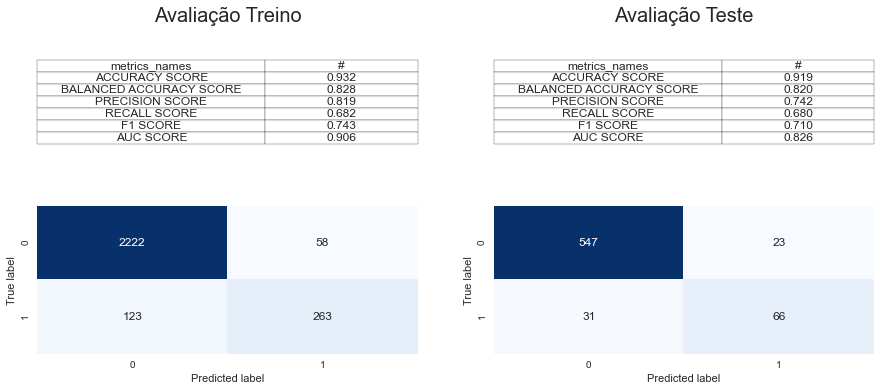

In [86]:
analisa_metricas_treino_teste(gra_1_grid_search.best_estimator_,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)

## 9.2 - Random Forest

### Random Forest Melhores Parametros 

In [175]:
for_clf=clf_dict["RandForest"]

param_grid = [
    {'n_estimators': [100, 200, 300, 400, 500, 1000, 1500, 2000],
     'criterion': ['gini', 'entropy'],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
     'min_samples_leaf': [2, 4, 6, 10, 15],
     'min_samples_split': [2, 5, 10, 15, 20],
     'max_features':['log2','sqrt','auto'],
     'warm_start': [True],
     'random_state':[seed],
     'bootstrap':[True, False]
    }
  ]

for_1_grid_search = RandomizedSearchCV(for_clf, param_grid, cv=5, verbose=1,
                           scoring='recall', return_train_score=True, n_jobs=-1, n_iter = 100, random_state = seed)
for_1_grid_search.fit(X_train_copy_v2, y_train_copy)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'criterion': ['gini', 'entropy'],
                                         'max_depth': [10, 20, 30, 40, 50, 60,
                                                       70, 80, 90, 100],
                                         'max_features': ['log2', 'sqrt',
                                                          'auto'],
                                         'min_samples_leaf': [2, 4, 6, 10, 15],
                                         'min_samples_split': [2, 5, 10, 15,
                                                               20],
                                         'n_estimators': [100, 200, 300, 400,
                                                          500, 1000, 1500,
                                     

In [176]:
for_1_grid_search.best_score_

0.6737262737262737

In [177]:
for_1_grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=2000, n_jobs=-1, random_state=42,
                       warm_start=True)

In [178]:
for_1_grid_search.best_params_

{'warm_start': True,
 'random_state': 42,
 'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 50,
 'criterion': 'gini',
 'bootstrap': False}


Done in 211.644546 s  
 



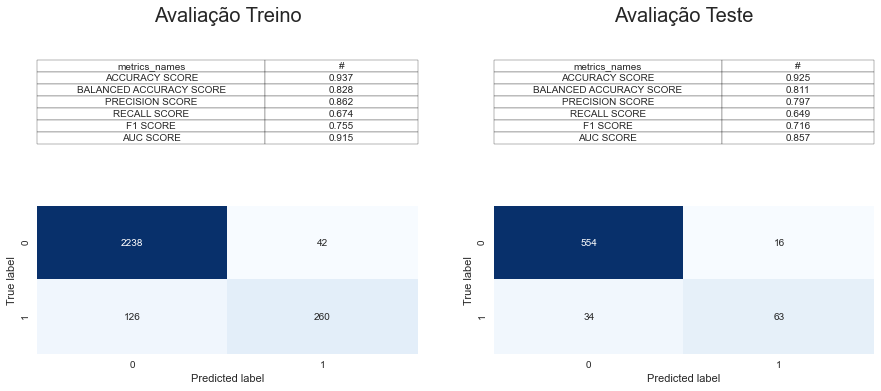

In [180]:
analisa_metricas_treino_teste(for_1_grid_search.best_estimator_,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)

#### Random Forest Melhores parametros e com max_depth=5 e class_weight={0: 1, 1: 4} 


Done in 244.263001 s  
 



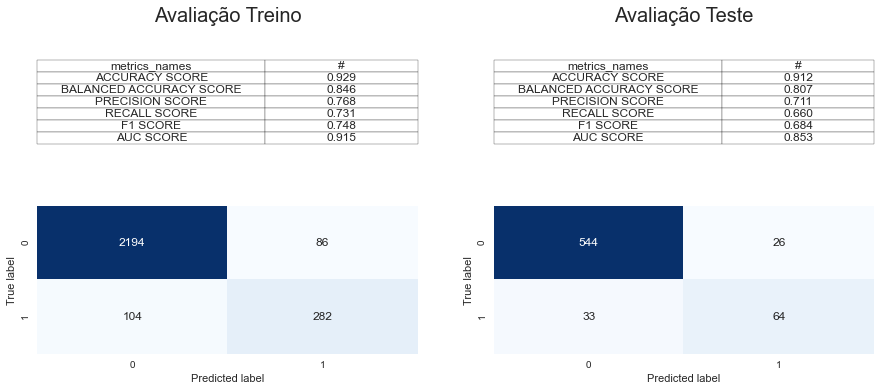

In [88]:
for_clf_2=RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=2000, n_jobs=-1, random_state=42,
                       warm_start=True, class_weight={0: 1, 1: 4}) 

for_clf_2 = for_clf_2.fit(X_train_copy_v2, y_train_copy)

analisa_metricas_treino_teste(for_clf_2,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)

#### Random Forest Melhores parametros e com max_depth=5 e class_weight={0: 1, 1: 6} 


Done in 241.235247 s  
 



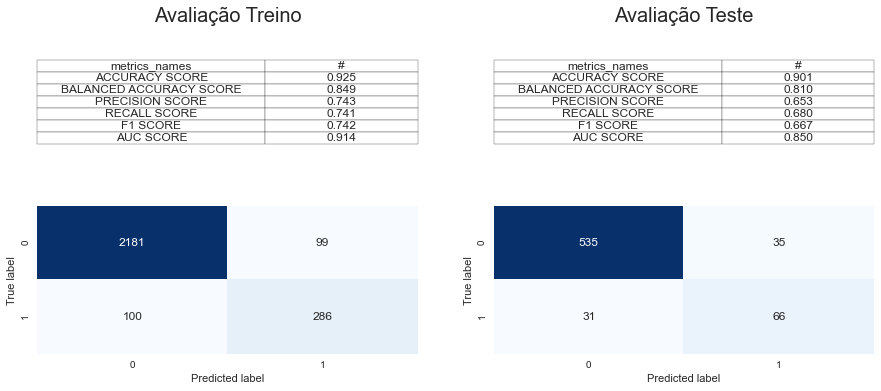

In [89]:
for_clf_3=RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=2000, n_jobs=-1, random_state=42,
                       warm_start=True, class_weight={0: 1, 1: 6}) 

for_clf_3 = for_clf_3.fit(X_train_copy_v2, y_train_copy)

analisa_metricas_treino_teste(for_clf_3,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)

#### Random Forest Melhores parametros e com max_depth=5 e class_weight={0: 1, 1: 12} 


Done in 244.592644 s  
 



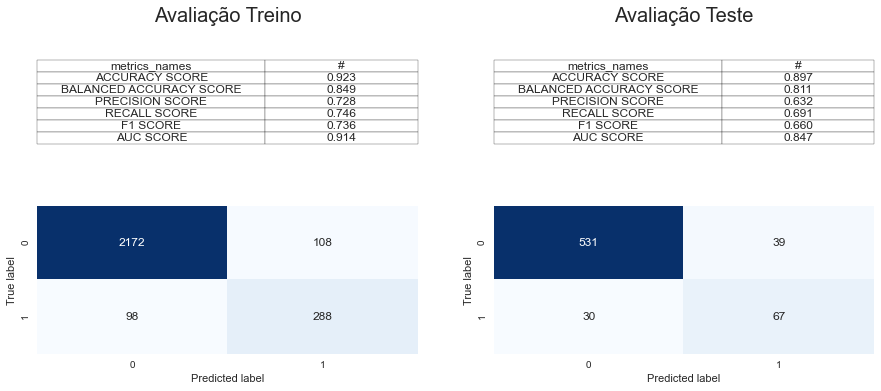

In [90]:
for_clf_4=RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=2000, n_jobs=-1, random_state=42,
                       warm_start=True, class_weight={0: 1, 1: 12}) 

for_clf_4 = for_clf_4.fit(X_train_copy_v2, y_train_copy)

analisa_metricas_treino_teste(for_clf_4,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)

#### Random Forest Melhores parametros e com max_depth=5 e class_weight={0: 1, 1: 24} 


Done in 238.309000 s  
 



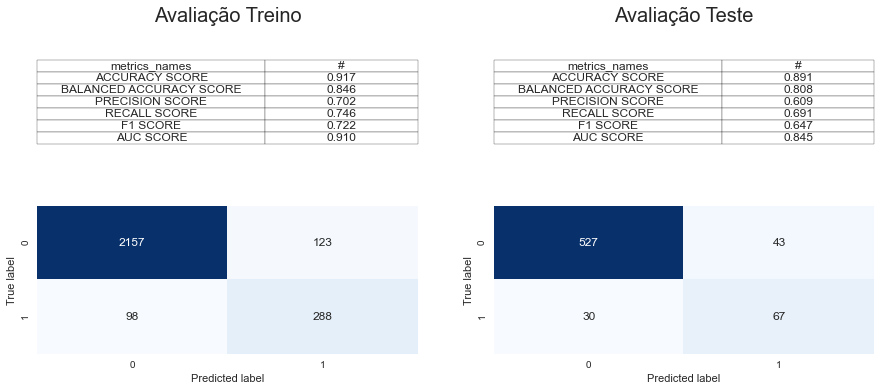

In [93]:
for_clf_5=RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=2000, n_jobs=-1, random_state=42,
                       warm_start=True, class_weight={0: 1, 1: 24}) 

for_clf_5 = for_clf_5.fit(X_train_copy_v2, y_train_copy)

analisa_metricas_treino_teste(for_clf_5,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)

## 9.3 - XGBOOST

### XGBOOST  Melhores Parametros  

In [95]:
xgb_clf=clf_dict["XGB"]

param_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 400, 500, 1000],
           'random_state': [seed]}

xgb_1_grid_search = RandomizedSearchCV(xgb_clf, param_grid, cv=5, verbose=1,
                           scoring='recall', return_train_score=True, n_jobs=-1, n_iter = 100, random_state = seed)
xgb_1_grid_search.fit(X_train_copy_v2, y_train_copy)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6,

In [182]:
xgb_1_grid_search.best_score_

0.6840825840825842

In [183]:
xgb_1_grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.8999999999999999, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7999999999999999, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [184]:
xgb_1_grid_search.best_params_

{'subsample': 0.7999999999999999,
 'random_state': 42,
 'n_estimators': 100,
 'max_depth': 15,
 'learning_rate': 0.2,
 'colsample_bytree': 0.8999999999999999,
 'colsample_bylevel': 0.7}


Done in 14.853787 s  
 



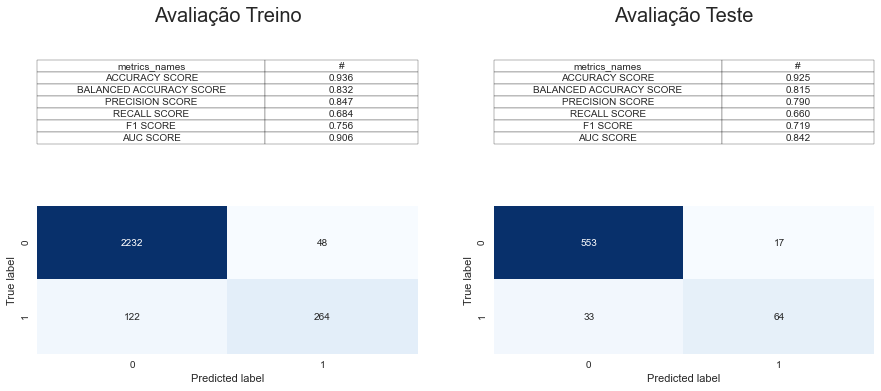

In [188]:
analisa_metricas_treino_teste(xgb_1_grid_search.best_estimator_,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)

## 9.4 - LightGBM 

### LightGBM Melhores Parametros com RandomizedSearch 

In [189]:
lgbm_clf=clf_dict["LGBM"]

param_grid = [
    {'n_estimators': [100, 200, 300, 400, 500, 1000, 1500, 2000, 5000, 10000],
     'learning_rate': [0.05, 0.1, 0.2, 0.3],
     'max_depth': [3, 5, 7, 9, 11],
     'num_leaves':[5, 15, 20, 30, 80, 100, 200, 300, 400, 500, 800, 1000, 1500, 1800],
     'min_data_in_leaf':[20 ,50, 100, 500, 700, 1000]
    }
  ]

lgbm_1_grid_search = RandomizedSearchCV(lgbm_clf, param_grid, cv=5, verbose=1,
                           scoring='recall', return_train_score=True, n_jobs=-1, n_iter = 200, random_state = seed)
lgbm_1_grid_search.fit(X_train_copy_v2, y_train_copy)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_iter=200,
                   n_jobs=-1,
                   param_distributions=[{'learning_rate': [0.05, 0.1, 0.2, 0.3],
                                         'max_depth': [3, 5, 7, 9, 11],
                                         'min_data_in_leaf': [20, 50, 100, 500,
                                                              700, 1000],
                                         'n_estimators': [100, 200, 300, 400,
                                                          500, 1000, 1500, 2000,
                                                          5000, 10000],
                                         'num_leaves': [5, 15, 20, 30, 80, 100,
                                                        200, 300, 400, 500, 800,
                                                        1000, 1500, 1800]}],
                   random_state=42, return_train_score=True, scoring='recall',
                   verbose=1)

In [190]:
lgbm_1_grid_search.best_score_

0.6789210789210789

In [191]:
lgbm_1_grid_search.best_estimator_

LGBMClassifier(learning_rate=0.05, max_depth=7, min_data_in_leaf=20,
               n_estimators=200, num_leaves=5, random_state=42)

In [192]:
lgbm_1_grid_search.best_params_

{'num_leaves': 5,
 'n_estimators': 200,
 'min_data_in_leaf': 20,
 'max_depth': 7,
 'learning_rate': 0.05}

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

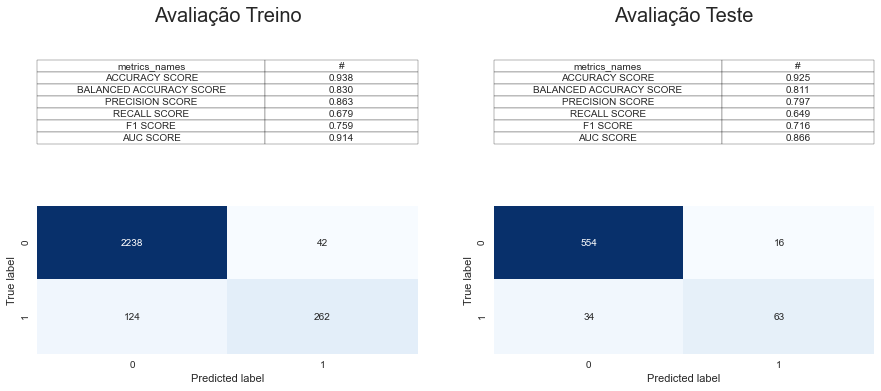

In [193]:
analisa_metricas_treino_teste(lgbm_1_grid_search.best_estimator_,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)

## 9.5 SVM

### SVM Melhores Parametros com GridSearch

In [72]:
svm_clf=clf_dict["SVM"]

param_grid = [
    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']#,
     #'gamma': [1, 5, 10, 20, 40, 80, 100],
     #'C': [0.1, 1, 5, 10, 20, 50, 100, 500, 1000],
     #'degree': [1, 2, 3, 4, 5, 6],
    }
  ]

svm_1_grid_search = GridSearchCV(svm_clf, param_grid, cv=5, verbose=1,
                           scoring='recall', return_train_score=True, n_jobs=-1)
svm_1_grid_search.fit(X_train_copy_v2, y_train_copy)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             return_train_score=True, scoring='recall', verbose=1)

In [73]:
svm_1_grid_search.best_params_

{'kernel': 'poly'}

In [74]:
svm_1_grid_search.best_score_

0.4845820845820846

In [76]:
svm_1_grid_search.best_estimator_

SVC(kernel='poly', random_state=42)

In [77]:
svm_1_grid_search.best_params_

{'kernel': 'poly'}


Done in 4.446161 s  
 



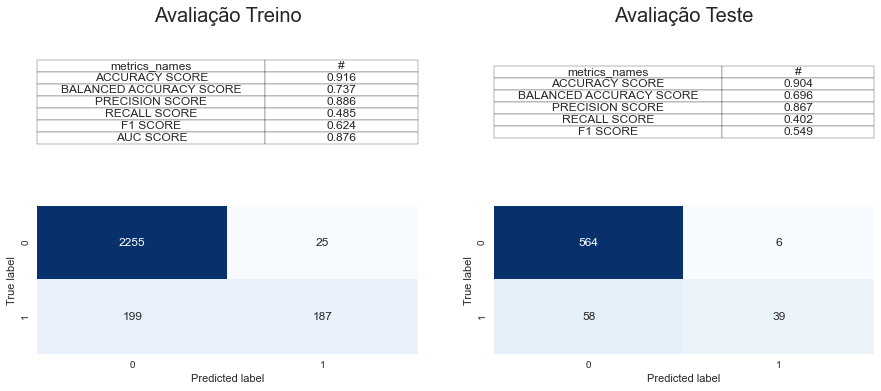

In [78]:
analisa_metricas_treino_teste(svm_1_grid_search.best_estimator_,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)

## 10 - Insights do Modelo e Avaliação de Melhor Fronteira de Decisão

In [62]:
xgb_clf=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.8999999999999999, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7999999999999999, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)


Done in 15.086673 s  
 



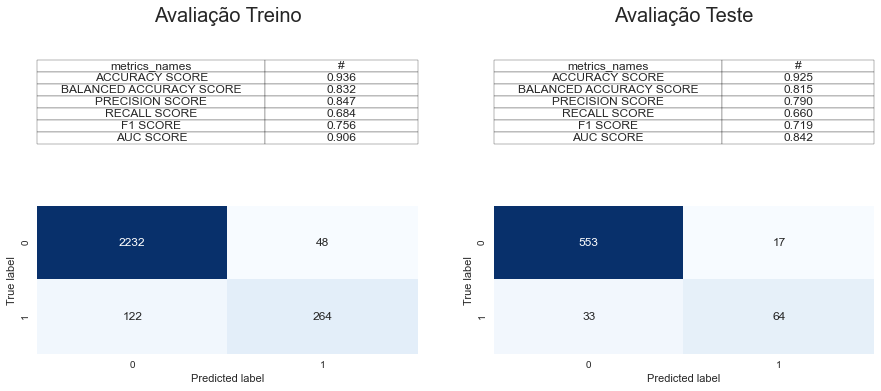

In [63]:
#MODELO ESCOLHIDO

xgb_clf = xgb_clf.fit(X_train_copy_v2, y_train_copy)

analisa_metricas_treino_teste(xgb_clf,
                              X_train_copy_v2, y_train_copy, X_test_copy_v2, y_test_copy, n_folds=5)

## 10.1 - Importância dos Atributos 

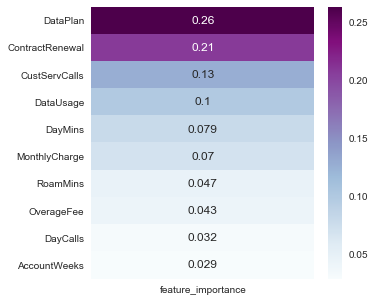

In [64]:
fig, axs = plt.subplots(figsize=(5, 5))

feature_importance_df=pd.DataFrame(index=X_train_copy_v2.columns,
                                   data={'feature_importance': xgb_clf.feature_importances_}).sort_values(by="feature_importance",
                                                                                                         ascending =False )

sns.heatmap(feature_importance_df, annot=True, cmap="BuPu")

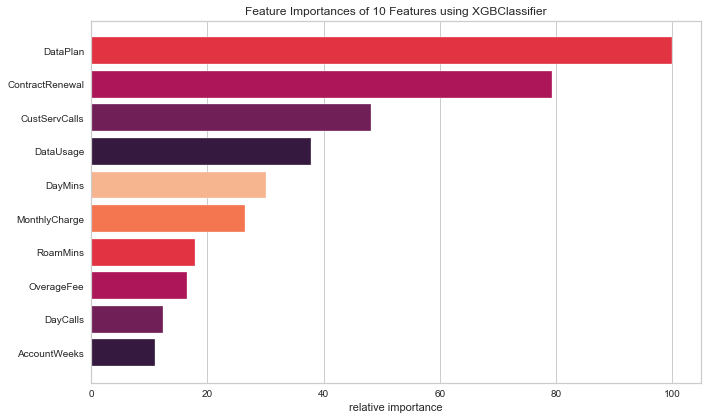

In [65]:
fig, ax = plt.subplots(figsize=(10,6))
fi_viz=FeatureImportances(xgb_clf)
fi_viz.fit(X_train_copy_v2, y_train_copy)
fi_viz.show()

## Exibindo Primeira Árvore

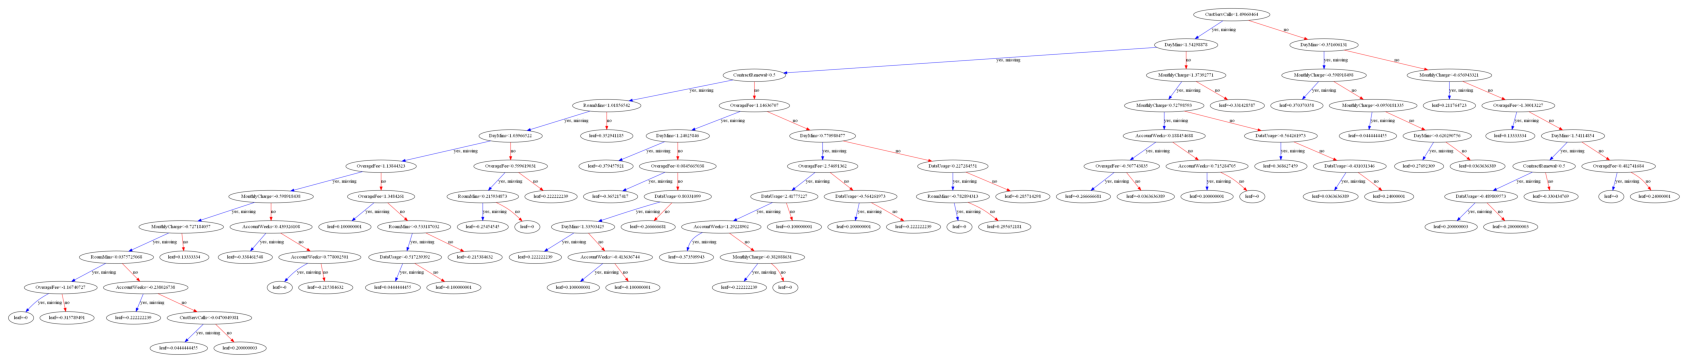

In [66]:
fig, ax=plt.subplots(figsize=(30,60))
xgb.plot_tree(xgb_clf, ax=ax, num_trees=0)

## 10.2 Relatório xgbfir 

In [67]:
xgbfir.saveXgbFI(
    xgb_clf,
    feature_names=X_train_copy_v2.columns,
    OutputXlsxFile="fir.xlsx")
pd.read_excel("fir.xlsx").T

,0,1,2,3,4,5,6,7,8,9
Interaction,DayMins,MonthlyCharge,CustServCalls,OverageFee,RoamMins,DataUsage,ContractRenewal,AccountWeeks,DayCalls,DataPlan
Gain,967.628,690.712,596.942,586.613,500.081,491.642,356.475,328.266,320.805,22.1954
FScore,579,471,223,641,503,234,81,539,469,4
wFScore,108.18,89.1668,51.0382,114.143,89.4295,37.0891,33.344,85.0507,73.7749,2.356
Average wFScore,0.18684,0.189314,0.228871,0.178071,0.177792,0.1585,0.411654,0.157794,0.157302,0.588999
Average Gain,1.6712,1.46648,2.67687,0.915153,0.994198,2.10103,4.40093,0.609027,0.68402,5.54885
Expected Gain,458.294,140.654,444.473,96.3865,70.2521,89.8253,268.968,48.094,45.363,5.97666
Gain Rank,1,2,3,4,5,6,7,8,9,10
FScore Rank,2,5,8,1,4,7,9,3,6,10
wFScore Rank,2,4,7,1,3,8,9,5,6,10


In [68]:
pd.read_excel("fir.xlsx", sheet_name="Interaction Depth 1").T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
Interaction,CustServCalls|DayMins,DataUsage|MonthlyCharge,DayMins|OverageFee,CustServCalls|MonthlyCharge,DayMins|MonthlyCharge,ContractRenewal|DayMins,DataUsage|DayMins,ContractRenewal|RoamMins,OverageFee|RoamMins,MonthlyCharge|OverageFee,AccountWeeks|MonthlyCharge,MonthlyCharge|MonthlyCharge,OverageFee|OverageFee,AccountWeeks|OverageFee,DayCalls|OverageFee,DayMins|RoamMins,ContractRenewal|OverageFee,MonthlyCharge|RoamMins,DataUsage|OverageFee,DataUsage|DayCalls,AccountWeeks|DayMins,AccountWeeks|RoamMins,ContractRenewal|CustServCalls,DayCalls|MonthlyCharge,DayCalls|DayMins,DataUsage|RoamMins,AccountWeeks|DayCalls,DayCalls|RoamMins,RoamMins|RoamMins,DayMins|DayMins,AccountWeeks|CustServCalls,DayCalls|DayCalls,CustServCalls|DayCalls,CustServCalls|OverageFee,AccountWeeks|AccountWeeks,CustServCalls|RoamMins,ContractRenewal|DayCalls,ContractRenewal|MonthlyCharge,AccountWeeks|DataUsage,ContractRenewal|DataUsage,AccountWeeks|ContractRenewal,DataUsage|DataUsage,CustServCalls|DataUsage,DataPlan|MonthlyCharge,DataPlan|DayMins,DataPlan|RoamMins,CustServCalls|CustServCalls,DataPlan|OverageFee,DataPlan|DayCalls,AccountWeeks|DataPlan
Gain,1175.39,757.866,679.971,658.119,588.1,531.932,479.321,416.236,356.063,316.482,296.545,281.597,269.131,268.249,263.231,249.965,249.202,241.318,238.62,229.293,215.559,198.017,195.03,189.477,188.355,162.393,150.412,148.594,143.866,139.466,122.789,117.72,114.172,113.98,108.955,100.602,96.7039,88.6018,74.0286,68.1568,49.7833,42.2346,41.3091,29.7132,25.2126,22.5536,19.778,2.76901,0.671933,0.590921
FScore,97,82,191,68,119,37,70,34,147,135,122,74,142,167,154,144,28,118,83,50,145,147,16,111,118,47,116,115,76,97,70,79,52,63,79,53,21,31,57,10,25,15,25,3,2,1,5,1,1,1
wFScore,23.0036,11.8845,27.954,15.0336,18.9414,14.754,9.35643,6.82997,20.3121,23.8382,17.4343,12.5729,28.8182,23.8961,21.864,23.4021,6.11785,20.6761,12.0903,6.01443,22.9485,25.6265,6.24776,14.2029,15.2314,7.84016,15.106,14.8985,11.9228,13.0803,8.90648,12.1338,8.7721,9.49795,10.8755,8.41668,6.04271,6.46105,6.83502,1.57605,4.9959,1.55789,2.50232,1.26007,0.268505,0.0874924,0.400518,0.083784,0.769389,0.230611
Average wFScore,0.23715,0.144932,0.146356,0.221082,0.159172,0.398758,0.133663,0.200881,0.138177,0.176579,0.142904,0.169903,0.202945,0.143091,0.141974,0.162514,0.218495,0.175221,0.145666,0.120289,0.158266,0.17433,0.390485,0.127954,0.129079,0.166812,0.130224,0.129552,0.156879,0.134849,0.127235,0.153592,0.168694,0.150761,0.137665,0.158805,0.287748,0.208421,0.119913,0.157605,0.199836,0.103859,0.100093,0.420024,0.134252,0.0874924,0.0801036,0.083784,0.769389,0.230611
Average Gain,12.1174,9.24226,3.56006,9.67822,4.94202,14.3765,6.84745,12.2422,2.4222,2.34431,2.4307,3.80536,1.89529,1.60628,1.70929,1.73587,8.90009,2.04507,2.87494,4.58585,1.48661,1.34705,12.1894,1.707,1.59623,3.45517,1.29666,1.29212,1.89298,1.4378,1.75413,1.49013,2.19562,1.8092,1.37918,1.89816,4.60495,2.85812,1.29875,6.81568,1.99133,2.81564,1.65236,9.90441,12.6063,22.5536,3.95559,2.76901,0.671933,0.590921
Expected Gain,672.062,120.626,70.8016,243.12,52.9487,405.789,34.3827,43.9464,37.5461,46.6949,38.6481,30.7681,42.5199,34.6631,32.086,31.0879,113.788,29.4476,21.7345,36.078,32.2858,29.6836,155.396,18.2697,16.8715,23.2166,17.3161,17.5433,18.6673,15.5856,19.6089,14.9464,43.0924,17.3738,12.3488,13.0702,43.0793,24.9091,8.01689,11.3715,14.8135,2.02732,4.93956,7.89798,4.10244,1.97327,1.4883,0.231999,0.516977,0.136273
Gain Rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
FScore Rank,17,20,1,27,11,34,25,35,4,9,10,24,8,2,3,7,37,12,19,32,6,5,41,16,13,33,14,15,23,18,26,21,31,28,22,30,40,36,29,43,38,42,39,45,46,47,44,48,49,50
wFScore Rank,7,25,2,16,12,18,28,34,11,5,13,21,1,4,9,6,37,10,23,39,8,3,36,19,14,32,15,17,24,20,29,22,30,27,26,31,38,35,33,42,40,43,41,44,47,49,46,50,45,48


In [69]:
pd.read_excel("fir.xlsx", sheet_name="Interaction Depth 2").T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Interaction,CustServCalls|DayMins|MonthlyCharge,ContractRenewal|CustServCalls|DayMins,ContractRenewal|DayMins|RoamMins,ContractRenewal|DayMins|OverageFee,DataUsage|MonthlyCharge|MonthlyCharge,DataUsage|DayMins|OverageFee,CustServCalls|DataUsage|MonthlyCharge,CustServCalls|DayMins|OverageFee,DataUsage|MonthlyCharge|RoamMins,DayMins|MonthlyCharge|OverageFee,ContractRenewal|CustServCalls|MonthlyCharge,AccountWeeks|CustServCalls|MonthlyCharge,DayMins|OverageFee|OverageFee,DayMins|MonthlyCharge|MonthlyCharge,DayMins|OverageFee|RoamMins,CustServCalls|MonthlyCharge|OverageFee,DataUsage|DayMins|MonthlyCharge,DataUsage|DayCalls|MonthlyCharge,DayMins|DayMins|OverageFee,ContractRenewal|OverageFee|RoamMins,DayCalls|DayMins|OverageFee,AccountWeeks|CustServCalls|DayMins,AccountWeeks|DataUsage|MonthlyCharge,AccountWeeks|OverageFee|RoamMins,CustServCalls|DayMins|DayMins,MonthlyCharge|OverageFee|RoamMins,CustServCalls|DayCalls|DayMins,DataUsage|DataUsage|MonthlyCharge,AccountWeeks|MonthlyCharge|OverageFee,DayCalls|OverageFee|RoamMins,AccountWeeks|DayMins|OverageFee,AccountWeeks|OverageFee|OverageFee,DataUsage|DayMins|RoamMins,DataUsage|MonthlyCharge|OverageFee,OverageFee|RoamMins|RoamMins,DayCalls|OverageFee|OverageFee,ContractRenewal|DayCalls|DayMins,CustServCalls|MonthlyCharge|MonthlyCharge,OverageFee|OverageFee|RoamMins,DayCalls|MonthlyCharge|OverageFee,DayCalls|MonthlyCharge|RoamMins,DataUsage|DayCalls|DayMins,AccountWeeks|DayCalls|MonthlyCharge,AccountWeeks|MonthlyCharge|MonthlyCharge,MonthlyCharge|OverageFee|OverageFee,CustServCalls|DayMins|RoamMins,AccountWeeks|DataUsage|OverageFee,AccountWeeks|DayMins|RoamMins,AccountWeeks|RoamMins|RoamMins,DayMins|MonthlyCharge|RoamMins,DayCalls|DayMins|MonthlyCharge,ContractRenewal|DataUsage|DayCalls,ContractRenewal|MonthlyCharge|OverageFee,AccountWeeks|DayCalls|OverageFee,AccountWeeks|CustServCalls|RoamMins,CustServCalls|DataUsage|DayMins,DayCalls|MonthlyCharge|MonthlyCharge,DataUsage|OverageFee|RoamMins,MonthlyCharge|MonthlyCharge|RoamMins,AccountWeeks|AccountWeeks|OverageFee,AccountWeeks|MonthlyCharge|RoamMins,AccountWeeks|DayMins|DayMins,AccountWeeks|AccountWeeks|MonthlyCharge,DataUsage|DataUsage|DayMins,ContractRenewal|CustServCalls|DayCalls,DayMins|RoamMins|RoamMins,MonthlyCharge|MonthlyCharge|OverageFee,AccountWeeks|DayCalls|RoamMins,ContractRenewal|DataUsage|DayMins,DayCalls|DayCalls|OverageFee,CustServCalls|DayCalls|MonthlyCharge,CustServCalls|DayCalls|OverageFee,OverageFee|OverageFee|OverageFee,AccountWeeks|DayCalls|DayMins,DayCalls|DayMins|RoamMins,ContractRenewal|CustServCalls|RoamMins,DayMins|DayMins|MonthlyCharge,ContractRenewal|DataUsage|MonthlyCharge,AccountWeeks|DayMins|MonthlyCharge,DayCalls|DayMins|DayMins,AccountWeeks|CustServCalls|OverageFee,AccountWeeks|AccountWeeks|RoamMins,ContractRenewal|MonthlyCharge|MonthlyCharge,ContractRenewal|OverageFee|OverageFee,DayCalls|DayCalls|RoamMins,AccountWeeks|AccountWeeks|DayMins,ContractRenewal|DataUsage|OverageFee,MonthlyCharge|MonthlyCharge|MonthlyCharge,DayMins|DayMins|RoamMins,CustServCalls|OverageFee|RoamMins,DayCalls|DayCalls|MonthlyCharge,AccountWeeks|ContractRenewal|DayCalls,DataUsage|DayCalls|DayCalls,DataUsage|RoamMins|RoamMins,AccountWeeks|DayCalls|DayCalls,AccountWeeks|ContractRenewal|MonthlyCharge,AccountWeeks|ContractRenewal|OverageFee,MonthlyCharge|RoamMins|RoamMins,CustServCalls|OverageFee|OverageFee,CustServCalls|CustServCalls|DayMins
Gain,1510.71,751.129,664.655,661.05,535.059,513.313,485.852,446.544,440.931,436.856,423.122,338.024,327.309,310.911,289.596,287.028,266.359,257.111,241.349,220.801,202.072,192.204,188.483,186.393,182.946,181.789,172.346,170.303,165.968,162.74,158.253,157.227,150.716,148.524,142.168,139.562,138.285,134.663,133.

## 10.3 - Curva de Aprendizagem

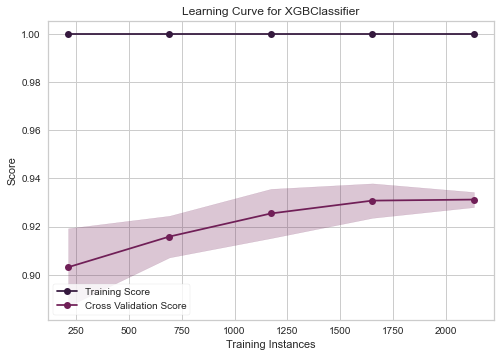

In [70]:
visualizer = LearningCurve(
    xgb_clf, cv=5, scoring='f1_weighted'
)

visualizer.fit(X_train_copy_v2, y_train_copy)
visualizer.show()

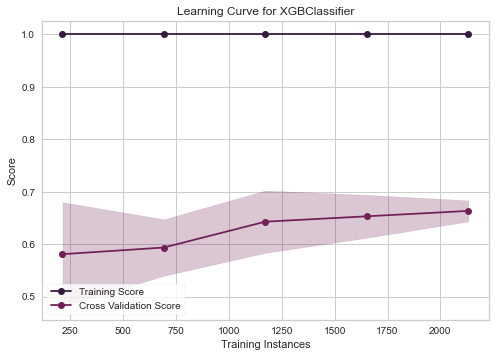

In [71]:
visualizer = LearningCurve(
    xgb_clf, cv=5, scoring='recall'
)

visualizer.fit(X_train_copy_v2, y_train_copy)
visualizer.show()

## 10.4 - Curva ROC

In [72]:
sns.set_palette("deep")

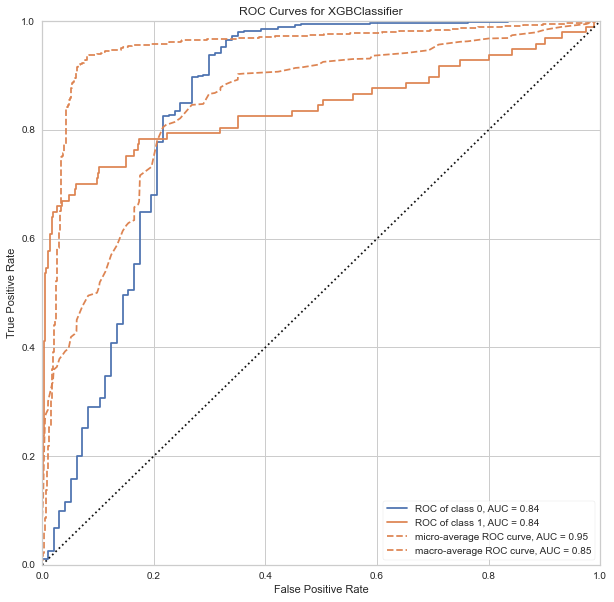

In [73]:
fig, axs = plt.subplots(figsize=(10,10))
visualizer = ROCAUC(xgb_clf, classes=[0, 1])

visualizer.fit(X_train_copy_v2, y_train_copy)
visualizer.score(X_test_copy_v2, y_test_copy)
visualizer.show()

## 10.5 - Curva Precisão-Recall

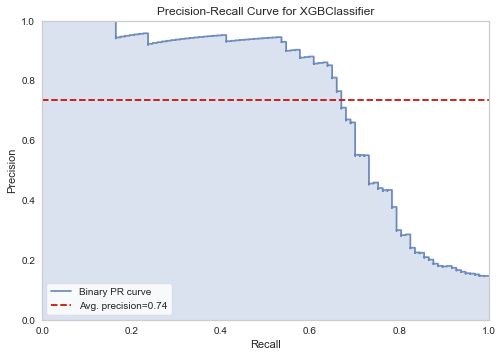

In [74]:
viz = PrecisionRecallCurve(xgb_clf)
viz.fit(X_train_copy_v2, y_train_copy)
viz.score(X_test_copy_v2, y_test_copy)
viz.show()

## 10.6 -  Gráfico de Ganho Cumulativo

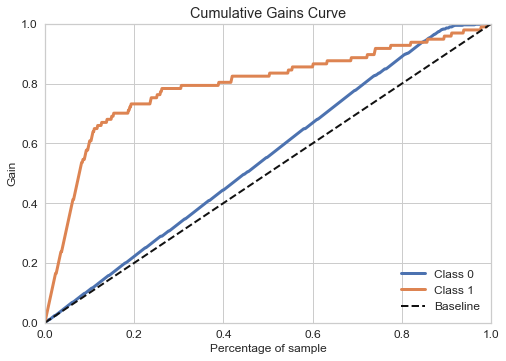

In [75]:
y_probas = xgb_clf.predict_proba(X_test_copy_v2)
skplt.metrics.plot_cumulative_gain(y_test_copy, y_probas)

plt.show()

## 10.7 -  Gráfico de Lift

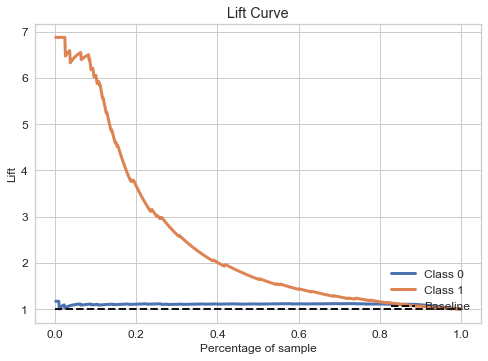

In [76]:
skplt.metrics.plot_lift_curve(y_test_copy, y_probas)
plt.show()

In [77]:
xgb_clf.predict_proba(X_train_copy_v2)

array([[9.9741352e-01, 2.5865138e-03],
       [1.2807131e-02, 9.8719287e-01],
       [9.9957526e-01, 4.2471531e-04],
       ...,
       [9.9925685e-01, 7.4316974e-04],
       [8.4163684e-01, 1.5836315e-01],
       [9.9931383e-01, 6.8618159e-04]], dtype=float32)

## 10.8 - Explicabilidade do modelo com Lime

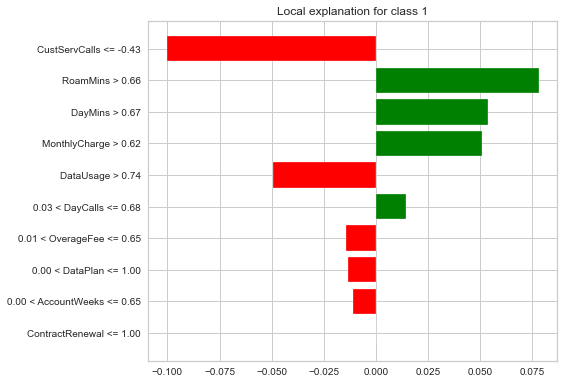

In [78]:
#Exemplo de cliente que é propenso a CHURN=0

explainer=lime_tabular.LimeTabularExplainer(
    X_train_copy_v2.values,
    feature_names=X_train_copy_v2.columns,
    class_names=[0, 1]
    )
exp=explainer.explain_instance(
    X_train_copy_v2.iloc[0].values, xgb_clf.predict_proba)
fig=exp.as_pyplot_figure()
fig.tight_layout()

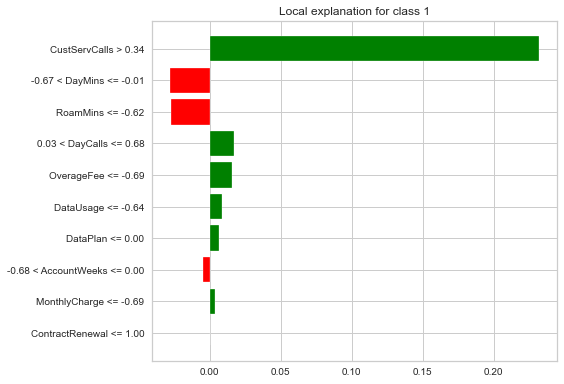

In [79]:
#Exemplo de cliente que é propenso a CHURN=1

exp=explainer.explain_instance(
    X_train_copy_v2.iloc[1].values, xgb_clf.predict_proba)
fig=exp.as_pyplot_figure()
fig.tight_layout()

## 10.9 - Avaliação de Melhor Fronteira de Decisão

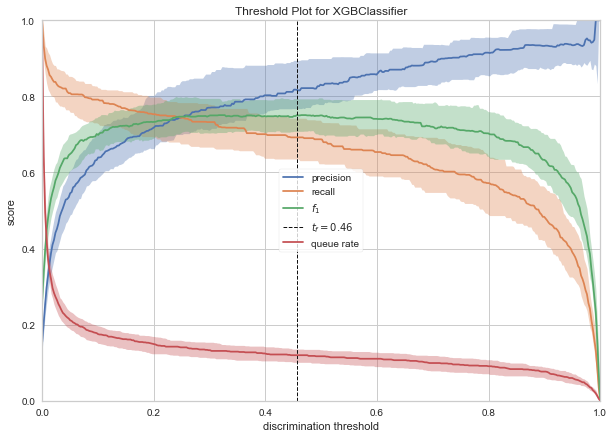

In [80]:
fig, axs = plt.subplots(figsize=(10,7))
visualizer = DiscriminationThreshold(xgb_clf, cv=0.2, random_state =seed)

visualizer.fit(X_train_copy_v2, y_train_copy)
visualizer.show()

### Alterando para Threshold=0.2

In [81]:
#Realizando predict_proba e selecionando apenas a probabilidade de Churn=1
train_proba=xgb_clf.predict_proba(X_train_copy_v2)[:, 1]
test_proba=xgb_clf.predict_proba(X_test_copy_v2)[:, 1]

In [82]:
#Definindo Threshold
threshold=0.2

In [83]:
#Criando base com as previsões com base no novo threshold

y_train_pred=train_proba>threshold
y_train_pred.astype(int)

y_test_pred=test_proba>threshold
y_test_pred=y_test_pred.astype(int)

###  Alterando threshold e aplicando validação cruzada em n folds

accuracy:  0.9201073704773348
balanced_accuracy:  0.8392057503899609
precision:  0.7286397786704203
recall:  0.7253413253413253
f1_score:  0.724511646803274
roc_auc:  0.8392057503899609


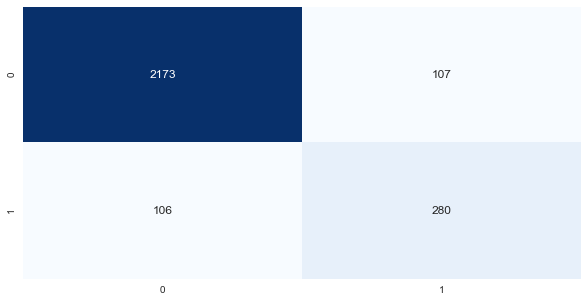

In [84]:
#Definindo listas de métricas vazias
acc=[]
blc_acc=[]
prc=[]
rec=[]
f1=[]
roc=[]
cm=np.array([[0,0],[0,0]])

#Definindo numéro de folds
skfolds = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#Iterando e abastecendo listas de métricas
for train_index, test_index in skfolds.split(X_train_copy_v2, y_train_copy):

    clone_clf = clone(xgb_clf)
    X_train_folds = X_train_copy_v2.iloc[train_index, :]
    y_train_folds = y_train_copy.iloc[train_index]
    X_test_fold = X_train_copy_v2.iloc[test_index, :]
    y_test_fold = y_train_copy.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred_fold = clone_clf.predict_proba(X_test_fold)[:, 1]>threshold
    y_pred_fold.astype(int)
    
    acc.append(accuracy_score(y_test_fold, y_pred_fold))
    blc_acc.append(balanced_accuracy_score(y_test_fold, y_pred_fold))
    prc.append(precision_score(y_test_fold, y_pred_fold))
    rec.append(recall_score(y_test_fold, y_pred_fold))
    f1.append(f1_score(y_test_fold , y_pred_fold))
    roc.append(roc_auc_score(y_test_fold, y_pred_fold))
    cm = confusion_matrix(y_test_fold, y_pred_fold) + cm

    
print("accuracy: ", sum(acc)/len(acc))
print("balanced_accuracy: ", sum(blc_acc)/len(blc_acc))
print("precision: ", sum(prc)/len(prc))
print("recall: ", sum(rec)/len(rec))
print("f1_score: ", sum(f1)/len(f1))
print("roc_auc: ", sum(roc)/len(roc))

#Plotando matriz de confusão
fig, axs = plt.subplots(figsize=(10, 5))

df_cm = pd.DataFrame(cm,
                 index = ['0','1'],
                 columns = ['0','1'])

sns.heatmap(df_cm, annot=True,cmap='Blues', cbar = 0, fmt='d')

####  Alterando threshold avaliando na base de teste

accuracy:  0.9025487256371814
balanced_accuracy:  0.8189365165491047
precision:  0.6538461538461539
recall 0.7010309278350515
f1_score 0.6766169154228855
roc_auc 0.8189365165491047


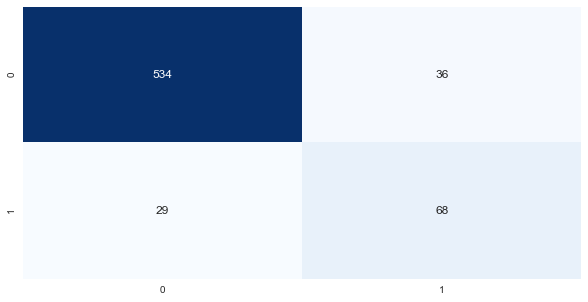

In [85]:
#Definindo Matriz de Confusão
cm = confusion_matrix(y_test_copy, y_test_pred)

#Cria um dataframe com a matriz de confusao

fig, axs = plt.subplots(figsize=(10, 5))

df_cm = pd.DataFrame(cm,
                 index = ['0','1'], 
                 columns = ['0','1'])

sns.heatmap(df_cm, annot=True,cmap='Blues', cbar = 0, fmt='d')

#Print nas principais métricas
print("accuracy: ", accuracy_score(y_test_copy, y_test_pred))
print("balanced_accuracy: ",balanced_accuracy_score(y_test_copy, y_test_pred))
print("precision: ", precision_score(y_test_copy, y_test_pred))
print("recall", recall_score(y_test_copy, y_test_pred))
print("f1_score", f1_score(y_test_copy, y_test_pred))
print("roc_auc", roc_auc_score(y_test_copy, y_test_pred))

## 11 - Conclusão

Modelo Xgboost teve boa performance na base de dados atual e obtivemos bons resultados em treino e teste. O recall aprimorado através de mudança de limiar do modelo e obtivemos melhor aderência para problema abordado.
Apesar da escolha e construção de modelo com o dataset fornecido, há a necessidade de coletar mais dados para treinamento de modelo com melhor desempenho, como avaliado na sessão 10.3. Além disso, pode ser interessante identificação de mais variáveis que possam impactar no Churn do cliente. 
Puderam ser percebidas algumas melhorias para o modelo atual, como a utilização de técnicas de seleção de atributos, visto que temos atributos com altas correlações. O tratamento de outliers também pode ser realizado para verificar possíveis melhorias no desempenho. Além disso, podem ser combinadas técnicas de undersampling e oversampling de forma a melhorar a qualidade do modelo final. Para futuras abordagens, também é valido, testar outros tipos de algoritmos e para os mesmos algoritmos, hiperparâmetros diferentes dos que foram avaliados.
